In [91]:
import ROOT
import numpy as np
import pandas as pd 
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter

ROOT.gROOT.ProcessLine( "gErrorIgnoreLevel = kError;");
ROOT.gStyle.SetCanvasDefW(2400);
ROOT.gStyle.SetCanvasDefH(900);
ROOT.gStyle.SetLegendTextSize(0.05)
ROOT.gStyle.SetLabelSize(0.05)
ROOT.gStyle.SetMarkerSize(1)
ROOT.gStyle.SetMarkerStyle(8)
ROOT.gStyle.SetLineWidth(2)
ROOT.gStyle.SetTextFont(42)
ROOT.gStyle.SetTextSize(0.05)
ROOT.gStyle.SetTickLength(0.02, "y")
ROOT.gStyle.SetHatchesSpacing(0.2) #to define the spacing between hatches.
ROOT.gStyle.SetHatchesLineWidth(1) #to define the hatches line width.

In [92]:
def human_readable(val):
    if int(val/1e9) > 0:
        return f"{int(val/1e9)}B"
    elif int(val/1e6) > 0:
        return f"{int(val/1e6)}M"
    elif int(val/1e3) > 0:
        return f"{int(val/1e3)}K"
    else:
        return str(int(val))

def map_env(e):
    if e == "CUDA_HIST":
        return "CUDA"
    elif e == "AdaptiveCpp": 
        return "ACPP"
    return e

def map_type(e):
    if e == "USM":
        return "PTR"
    elif e == "Buffers": 
        return "BUF"
    return e
    
def add_file(df, file, new_cols):
    new_df = pd.read_csv(file)
    new_df["nvals"] =  new_df["input"].apply(lambda s: np.float64(s.split("_")[-1].split(".")[0]))
    new_df["distribution"] =  new_df["input"].apply(lambda s: s.split("_")[1])
    convert_to_type(new_df, "edges", np.bool_)
    if "ttotal" in new_df:
        convert_to_type(new_df, "ttotal", np.float64)
    for k,v in new_cols.items():
        new_df[k] = v
    df = pd.concat([df, new_df])
    return df

In [122]:
def convert_to_type(df, col, type):
    df[col] =  df[col].apply(lambda s: type(s))

def normalize_df(df, cols, norm):
    for col in cols:
        df[col] = df[col].div(df[norm])

def filter_name(n):
    # print(n)
    name_map = {
        "Stats" : "Reductions",
        "Sum" : "Reductions",
        "Histo" : "Histogram",
        "ExcludeUOverflowKernel" : "Other",
        "InitializeToZeroTask" : "Other"
    }
    for w in ["unsigned", "int", "char", "float", "void", "const", "long", "*", "hipsycl_kernel",
              "::operator", "ROOT::", "Experimental::", "_", "::", "]", "[", "  "]:
        n = n.replace(w, "")
    for k,v in name_map.items():
        if k in n:
            n = v

    return n.strip()

def get_cell(df, index_name, col):
    return df.loc[index_name][col]
    
def fill_bar(h, x, w, d, c, s):
    h.Fill(x, w)
    h.SetBinError(h.FindBin(x), d)
    if s:
        h.SetFillStyle(s)
    h.SetLineColor(c)
    h.SetFillColor(c)
    h.SetLineWidth(2)
    h.SetMarkerSize(0)

default_clr = ROOT.kGray+2
def get_group(n):
    if n in [
        "cuModuleLoadDataEx",
        "cuModuleUnload",
        "cuModuleGetLoadingMode",
        "cuCtxSetCurrent",
    ]:
        return "Module"
    elif n in [
        "cuEventCreate",
        "cuEventDestroy_v2",
        "cuEventQuery",
        "cuEventRecord",
        "cuEventSynchronize",
        "cudaEventCreate",
        "cudaEventDestroy",
        "cudaEventRecord",
        "cudaEventSynchronize",
    ]:
        return "Event"
    elif n in [
        "cuMemAlloc_v2",
        "cuMemFree_v2",
        "cuMemcpyAsync",
        "cuMemcpyHtoDAsync_v2",
        "cuMemcpyDtoHAsync_v2",
        "cuMemsetAsync",
        "cudaMalloc",
        "cudaFree",
        "cudaMemcpyAsync",
        "cudaMemsetAsync",
        "cuMemsetD8Async",
        "CUDAMalloc",
        "CUDAFree",
        "cudaMemcpy",
        "cudaMemset",
    ]:
        return "Memory"
    elif n in [
        "cuStreamWaitEvent",
        "cuStreamCreateWithPriority",
        "cuStreamDestroy_v2",
        "cuStreamCreateWithFlags",
        "cudaStreamCreateWithFlags",
        "cudaStreamDestroy",
        "cudaStreamWaitEvent",
        "cuStreamSynchronize",
    ]:
        return "Stream"
    elif n in [
        "cuLaunchKernel",
        "cudaLaunchKernel",
        "CUDALaunchKernel",
    ]:
        return "Kernel"
    elif n in [
        "cuGetDevicePropertiesv2v12000",
        "cudaGetDeviceProperties_v2_v12000",
    ]:
        return "Properties"
    print(n)

def get_group_color(name):
    g_dict = {
        "Event" : ROOT.kGreen,
        "Kernel" : ROOT.kOrange,
        "Module" : ROOT.kBlue,
        "Memory" : ROOT.kRed,
        "Stream" : ROOT.kMagenta,
        "Properties" : default_clr
    }

    if name in g_dict:
        return g_dict[name]

def get_color(name, lbls=[]):
    c_dict = {
        "cuModuleLoadDataEx" : ROOT.kBlue,
        "cuModuleUnload" : ROOT.kBlue+1,
        "cuModuleGetLoadingMode": ROOT.kBlue+2,
        "cuEventCreate": ROOT.kGreen,
        "cuEventDestroy_v2": ROOT.kGreen+1,
        "cuEventQuery": ROOT.kGreen+2,
        "cuEventRecord": ROOT.kGreen+3,
        "cuEventSynchronize": ROOT.kGreen+4,
        "cuGetDevicePropertiesv2v12000": ROOT.kBlack,
        "cuLaunchKernel": ROOT.kOrange,
        "cuMemAlloc_v2": ROOT.kRed,
        "cuMemFree_v2": ROOT.kRed+1,
        "cuMemcpyAsync": ROOT.kRed+2,
        "cuMemsetAsync": ROOT.kRed+3,
        "cuStreamCreateWithFlags": ROOT.kMagenta,
        "cuStreamCreateWithPriority": ROOT.kMagenta+1,
        "cuStreamDestroy_v2": ROOT.kMagenta+2,
        "cuStreamWaitEvent": ROOT.kMagenta+3,
        
        "cudaEventCreate": ROOT.kGreen,
        "cudaEventDestroy": ROOT.kGreen+1,
        "cudaEventRecord": ROOT.kGreen+3,
        "cudaEventSynchronize": ROOT.kGreen+4,
        "cudaGetDevicePropertiesv2v12000": ROOT.kBlack,
        "cudaLaunchKernel": ROOT.kOrange,
        "cudaMalloc": ROOT.kRed,
        "cudaFree": ROOT.kRed+1,
        "cudaMemcpyAsync": ROOT.kRed+2,
        "cudaMemsetAsync": ROOT.kRed+3,
        "cudaStreamCreateWithFlags": ROOT.kMagenta,
        "cudaStreamDestroy": ROOT.kMagenta+2,
        "cudaStreamWaitEvent": ROOT.kMagenta+3,
        
        "cudaLaunchKernel": ROOT.kOrange,
        "cudaMalloc": ROOT.kRed,
        "cudaFree": ROOT.kRed+1,
        "cudaMemcpy": ROOT.kRed+2,
        "cudaMemset": ROOT.kRed+3,
    }

    if name in c_dict:
        return c_dict[name]

gpuFillStyle = {
    "DPC++" : 3690,
    "AdaptiveCpp": 3644,
    "CUDA" : 3350,
}

gpuFillStyle = {
    "DPC++" : None,
    "AdaptiveCpp": None,
    "CUDA" : None,
}


In [94]:
groupby_list = ["env", "gpu", "cc", "type", "distribution", "nvals", "nbins", "bulksize", "edges", "reduction"]

In [95]:
df = pd.read_csv("das6-gpu/final_results")
df["nvals"] =  df["input"].apply(lambda s: np.float64(s.split("_")[-1].split(".")[0]))
df["distribution"] =  df["input"].apply(lambda s: s.split("_")[1])
convert_to_type(df, "edges", np.bool_)
convert_to_type(df, "ttotal", np.float64)

del df["input"]
df

,iter,env,cc,type,gpu,nbins,bulksize,edges,reduction,tfindbin,tfill,tstats,ttotal,nvals,distribution
0,0,AdaptiveCpp,86,Buffers,A4000,1000,32768,True,2,0.0,0.0,0.0,2.620880,5.000000e+07,uniform
1,0,AdaptiveCpp,86,Buffers,A4000,1000,32768,True,2,0.0,0.0,0.0,4.066375,1.000000e+08,uniform
2,0,AdaptiveCpp,86,Buffers,A4000,1000,32768,True,2,0.0,0.0,-0.0,15.221615,5.000000e+08,uniform
3,0,AdaptiveCpp,86,Buffers,A4000,1000,32768,True,2,0.0,-0.0,0.0,29.476149,1.000000e+09,uniform
4,1,AdaptiveCpp,86,Buffers,A4000,1000,32768,True,2,0.0,0.0,0.0,2.660163,5.000000e+07,uniform
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,3,DPC++,86,Buffers,A4000,1000,32768,True,2,0.0,0.0,0.0,17.522725,1.000000e+09,uniform
96,4,DPC++,86,Buffers,A4000,1000,32768,True,2,0.0,0.0,0.0,2.939445,5.000000e+07,uniform
97,4,DPC++,86,Buffers,A4000,1000,32768,True,2,0.0,0.0,0.0,4.023469,1.000000e+08,uniform
98,4,DPC++,86,Buffers,A4000,1000,32768,True,2,0.0,0.0,0.0,9.873230,5.000000e+08,uniform


In [96]:
gp = df.groupby(groupby_list)
gp.mean()

iter  \
env         gpu   cc type    distribution nvals        nbins bulksize edges reduction         
AdaptiveCpp A4000 86 Buffers uniform      5.000000e+07 1000  32768    True  2           2.0   
                                          1.000000e+08 1000  32768    True  2           2.0   
                                          5.000000e+08 1000  32768    True  2           2.0   
                                          1.000000e+09 1000  32768    True  2           2.0   
                     USM     uniform      5.000000e+07 1000  32768    True  2           2.0   
                                          1.000000e+08 1000  32768    True  2           2.0   
                                          5.000000e+08 1000  32768    True  2           2.0   
                                          1.000000e+09 1000  32768    True  2           2.0   
CUDA        A4000 86 Buffers uniform      5.000000e+07 1000  32768    True  2           2.0   
                                          1.000000e+08 1000  32768    True  2           2.0   
                                          5.000000e+08 1000  32768    True  2           2.0   
                                          1.000000e+09 1000  32768    True  2           2.0   
DPC++       A4000 86 Buffers uniform      5.000000e+07 1000  32768    True  2           2.0   
                                          1.000000e+08 1000  32768    True  2           2.0   
                                          5.000000e+08 1000  32768    True  2           2.0   
                                          1.000000e+09 1000  32768    True  2           2.0   
                     USM     uniform      5.000000e+07 1000  32768    True  2           2.0   
                                          1.000000e+08 1000  32768    True  2           2.0   
                                          5.000000e+08 1000  32768    True  2           2.0   
                                          1.000000e+09 1000  32768    True  2           2.0   

                                                                                            tfindbin  \
env         gpu   cc type    distribution nvals        nbins bulksize edges reduction                  
AdaptiveCpp A4000 86 Buffers uniform      5.000000e+07 1000  32768    True  2           0.000000e+00   
                                          1.000000e+08 1000  32768    True  2           0.000000e+00   
                                          5.000000e+08 1000  32768    True  2           0.000000e+00   
                                          1.000000e+09 1000  32768    True  2           0.000000e+00   
                     USM     uniform      5.000000e+07 1000  32768    True  2           0.000000e+00   
                                          1.000000e+08 1000  32768    True  2           0.000000e+00   
                                          5.000000e+08 1000  32768    True  2           0.000000e+00   
                                          1.000000e+09 1000  32768    True  2           0.000000e+00   
CUDA        A4000 86 Buffers uniform      5.000000e+07 1000  32768    True  2         -1.633566e+298   
                                          1.000000e+08 1000  32768    True  2           0.000000e+00   
                                          5.000000e+08 1000  32768    True  2           0.000000e+00   
                                          1.000000e+09 1000  32768    True  2           3.400000e-02   
DPC++       A4000 86 Buffers uniform      5.000000e+07 1000  32768    True  2           0.000000e+00   
                                          1.000000e+08 1000  32768    True  2           0.000000e+00   
                                          5.000000e+08 1000  32768    True  2           0.000000e+00   
                                          1.000000e+09 1000  32768    True  2           0.000000e+00   
                     USM     uniform      5.000000e+07 1000  32768    True  2           0.000000e+00   
                    

In [97]:
unique_env = df["env"].unique()
unique_bulksize = np.sort(df["bulksize"].unique())
unique_nbins = np.sort(df["nbins"].unique())
unique_nvals = np.sort(df["nvals"].unique().astype(np.float64))
unique_gpus = df["gpu"].unique()
unique_distributions = df["distribution"].unique()
unique_edges = [True, False]
unique_type = ["Buffers", "USM"]
unique_cc = [75,86]
unique_reduction = np.sort(df["reduction"].unique())
unique_env, unique_gpus, unique_type, unique_nbins, unique_bulksize, unique_edges, unique_nvals, unique_distributions, unique_cc, unique_reduction

(array(['AdaptiveCpp', 'CUDA', 'DPC++'], dtype=object),
 array(['A4000'], dtype=object),
 ['Buffers', 'USM'],
 array([1000]),
 array([32768]),
 [True, False],
 array([5.e+07, 1.e+08, 5.e+08, 1.e+09]),
 array(['uniform'], dtype=object),
 [75, 86],
 array([2]))

In [98]:
api_buf = pd.read_csv("das6-gpu/nsys-final_results/api")
api_buf["nvals"] =  api_buf["input"].apply(lambda s: np.float64(s.split("_")[-1].split(".")[0]))
api_buf["distribution"] =  api_buf["input"].apply(lambda s: s.split("_")[1])
convert_to_type(api_buf, "edges", np.bool_)
api = api_buf

api["Time"] = api["Total Time (ns)"].div(1e9)
del api["input"]
api_filtered = api.copy()
api_filtered["Name"] = api_filtered["Name"].apply(get_group)
api

,iter,env,cc,type,gpu,nbins,bulksize,edges,reduction,Time (%),...,Num Calls,Avg (ns),Med (ns),Min (ns),Max (ns),StdDev (ns),Name,nvals,distribution,Time
0,0,AdaptiveCpp,86,Buffers,A4000,1000,32768,True,2,30.9,...,10690,20814.0,7844.0,6833,128020521,1238128.4,cudaLaunchKernel,5.000000e+07,uniform,0.222502
1,0,AdaptiveCpp,86,Buffers,A4000,1000,32768,True,2,25.7,...,4,46388056.5,6086.5,4478,185535575,92765012.3,cudaStreamCreateWithFlags,5.000000e+07,uniform,0.185552
2,0,AdaptiveCpp,86,Buffers,A4000,1000,32768,True,2,21.2,...,3065,49942.1,52008.0,5881,106540,5589.9,cudaMemcpyAsync,5.000000e+07,uniform,0.153073
3,0,AdaptiveCpp,86,Buffers,A4000,1000,32768,True,2,6.4,...,10707,4303.2,4208.0,3356,50465,1166.0,cudaEventRecord,5.000000e+07,uniform,0.046074
4,0,AdaptiveCpp,86,Buffers,A4000,1000,32768,True,2,6.0,...,6119,7035.6,7595.0,3327,272421,4353.8,cudaFree,5.000000e+07,uniform,0.043051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1394,4,DPC++,86,Buffers,A4000,1000,32768,True,2,0.0,...,145,767.4,671.0,491,3146,323.4,cuStreamSynchronize,1.000000e+09,uniform,0.000111
1395,4,DPC++,86,Buffers,A4000,1000,32768,True,2,0.0,...,2,13620.5,13620.5,11752,15489,2642.5,cuMemcpyAsync,1.000000e+09,uniform,0.000027
1396,4,DPC++,86,Buffers,A4000,1000,32768,True,2,0.0,...,1,18415.0,18415.0,18415,18415,0.0,cuMemcpyDtoHAsync_v2,1.000000e+09,uniform,0.000018
1397,4,DPC++,86,Buffers,A4000,1000,32768,True,2,0.0,...,1,11722.0,11722.0,11722,11722,0.0,cuMemsetD8Async,1.000000e+09,uniform,0.000012


In [99]:
gp_api = api.groupby([*groupby_list, "Name"])
gp_api_filtered = api_filtered.groupby([*groupby_list, "iter", "Name"], as_index=False).sum()
gp_api_filtered = gp_api_filtered.groupby([*groupby_list, "Name"])
gp_api.mean()

iter  \
env         gpu   cc type    distribution nvals        nbins bulksize edges reduction Name                               
AdaptiveCpp A4000 86 Buffers uniform      5.000000e+07 1000  32768    True  2         cuModuleGetLoadingMode       2.0   
                                                                                      cudaEventCreate              2.0   
                                                                                      cudaEventDestroy             2.0   
                                                                                      cudaEventRecord              2.0   
                                                                                      cudaEventSynchronize         2.0   
...                                                                                                                ...   
DPC++       A4000 86 USM     uniform      1.000000e+09 1000  32768    True  2         cuModuleUnload               2.0   
                                                                                      cuStreamCreateWithPriority   2.0   
                                                                                      cuStreamDestroy_v2           2.0   
                                                                                      cuStreamSynchronize          2.0   
                                                                                      cuStreamWaitEvent            2.0   

                                                                                                                  Time (%)  \
env         gpu   cc type    distribution nvals        nbins bulksize edges reduction Name                                   
AdaptiveCpp A4000 86 Buffers uniform      5.000000e+07 1000  32768    True  2         cuModuleGetLoadingMode          0.00   
                                                                                      cudaEventCreate                 0.00   
                                                                                      cudaEventDestroy                0.00   
                                                                                      cudaEventRecord                 6.48   
                                                                                      cudaEventSynchronize            1.78   
...                                                                                                                    ...   
DPC++       A4000 86 USM     uniform      1.000000e+09 1000  32768    True  2         cuModuleUnload                  1.70   
                                                                                      cuStreamCreateWithPriority      0.10   
                                                                                      cuStreamDestroy_v2              0.00   
                                                                                      cuStreamSynchronize             0.00   
                                                                                      cuStreamWaitEvent               1.90   

                                                                                                                  Total Time (ns)  \
env         gpu   cc type    distribution nvals        nbins bulksize edges reduction Name                                          
AdaptiveCpp A4000 86 Buffers uniform      5.000000e+07 1000  32768    True  2         cuModuleGetLoadingMode               3428.2   
                                                                                      cudaEventCreate                    235467.2   
                                                                                      cudaEventDestroy                    29148.4   
                                                                                      cudaEventRecord                  46575646.6   
                                                                                      cuda

In [100]:
gp_api = api.groupby([*groupby_list, "Name"])
gp_api_filtered = api_filtered.groupby([*groupby_list, "iter", "Name"], as_index=False).sum()
gp_api_filtered = gp_api_filtered.groupby([*groupby_list, "Name"])
gp_api_filtered.mean().loc["AdaptiveCpp"]

iter  \
gpu   cc type    distribution nvals        nbins bulksize edges reduction Name               
A4000 86 Buffers uniform      5.000000e+07 1000  32768    True  2         Event        2.0   
                                                                          Kernel       2.0   
                                                                          Memory       2.0   
                                                                          Module       2.0   
                                                                          Properties   2.0   
                                                                          Stream       2.0   
                              1.000000e+08 1000  32768    True  2         Event        2.0   
                                                                          Kernel       2.0   
                                                                          Memory       2.0   
                                                                          Module       2.0   
                                                                          Properties   2.0   
                                                                          Stream       2.0   
                              5.000000e+08 1000  32768    True  2         Event        2.0   
                                                                          Kernel       2.0   
                                                                          Memory       2.0   
                                                                          Module       2.0   
                                                                          Properties   2.0   
                                                                          Stream       2.0   
                              1.000000e+09 1000  32768    True  2         Event        2.0   
                                                                          Kernel       2.0   
                                                                          Memory       2.0   
                                                                          Module       2.0   
                                                                          Properties   2.0   
                                                                          Stream       2.0   
         USM     uniform      5.000000e+07 1000  32768    True  2         Event        2.0   
                                                                          Kernel       2.0   
                                                                          Memory       2.0   
                                                                          Module       2.0   
                                                                          Properties   2.0   
                                                                          Stream       2.0   
                              1.000000e+08 1000  32768    True  2         Event        2.0   
                                                                          Kernel       2.0   
                                                                          Memory       2.0   
                                                                          Module       2.0   
                                                                          Properties   2.0   
                                                                          Stream       2.0   
                              5.000000e+08 1000  32768    True  2         Event        2.0   
                                                                          Kernel       2.0   
                                                                          Memory       2.0   
                                                                          Module       2.0   
                                                                          Properties   2.0   
                                            

In [101]:
api_names = api["Name"].unique()
api_filtered_names = api_filtered["Name"].unique()
api_names

array(['cudaLaunchKernel', 'cudaStreamCreateWithFlags', 'cudaMemcpyAsync',
       'cudaEventRecord', 'cudaFree', 'cudaMalloc',
       'cudaEventSynchronize', 'cudaStreamWaitEvent', 'cudaEventCreate',
       'cudaGetDeviceProperties_v2_v12000', 'cudaStreamDestroy',
       'cudaEventDestroy', 'cudaMemsetAsync', 'cuModuleGetLoadingMode',
       'cudaMemcpy', 'cudaMemset', 'cuModuleUnload', 'cuMemcpyAsync',
       'cuLaunchKernel', 'cuEventSynchronize', 'cuMemAlloc_v2',
       'cuMemFree_v2', 'cuEventQuery', 'cuEventRecord',
       'cuStreamWaitEvent', 'cuEventCreate', 'cuStreamCreateWithPriority',
       'cuEventDestroy_v2', 'cuStreamDestroy_v2', 'cuStreamSynchronize',
       'cuMemsetD8Async', 'cuCtxSetCurrent', 'cuModuleLoadDataEx',
       'cuMemcpyHtoDAsync_v2', 'cuMemcpyDtoHAsync_v2'], dtype=object)

In [102]:
kernels_buf = pd.read_csv("das6-gpu/nsys-final_results/kernel")
kernels_buf["nvals"] =  kernels_buf["input"].apply(lambda s: np.float64(s.split("_")[-1].split(".")[0]))
kernels_buf["distribution"] =  kernels_buf["input"].apply(lambda s: s.split("_")[1])
convert_to_type(kernels_buf, "edges", np.bool_)

kernels = kernels_buf
kernels["Time"] = kernels["Total Time (ns)"].div(1e9)
del kernels["input"]
kernels_unfiltered = kernels.copy()
kernels["Name"] = kernels["Name"].apply(filter_name)
kernels

,iter,env,cc,type,gpu,nbins,bulksize,edges,reduction,Time (%),...,Instances,Avg (ns),Med (ns),Min (ns),Max (ns),StdDev (ns),Name,nvals,distribution,Time
0,0,AdaptiveCpp,86,Buffers,A4000,1000,32768,True,2,34.7,...,1527,10558.3,10560.0,6912,11552,112.8,Histogram,5.000000e+07,uniform,0.016123
1,0,AdaptiveCpp,86,Buffers,A4000,1000,32768,True,2,16.8,...,1527,5120.2,5120.0,4160,5408,33.3,Reductions,5.000000e+07,uniform,0.007819
2,0,AdaptiveCpp,86,Buffers,A4000,1000,32768,True,2,15.6,...,1527,4748.1,4736.0,3936,5120,33.1,Reductions,5.000000e+07,uniform,0.007250
3,0,AdaptiveCpp,86,Buffers,A4000,1000,32768,True,2,11.1,...,1527,3388.5,3392.0,3328,3425,12.6,Reductions,5.000000e+07,uniform,0.005174
4,0,AdaptiveCpp,86,Buffers,A4000,1000,32768,True,2,11.1,...,1527,3375.3,3361.0,3359,3424,16.0,Reductions,5.000000e+07,uniform,0.005154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
760,4,DPC++,86,Buffers,A4000,1000,32768,True,2,8.1,...,30534,2656.2,2656.0,2240,2689,10.1,Reductions,1.000000e+09,uniform,0.081106
761,4,DPC++,86,Buffers,A4000,1000,32768,True,2,8.1,...,30534,2656.0,2656.0,2208,2689,9.6,Reductions,1.000000e+09,uniform,0.081098
762,4,DPC++,86,Buffers,A4000,1000,32768,True,2,5.1,...,30446,1660.8,1664.0,1631,3552,22.4,Other,1.000000e+09,uniform,0.050563
763,4,DPC++,86,Buffers,A4000,1000,32768,True,2,0.0,...,88,2470.6,2752.0,1728,2784,408.4,Other,1.000000e+09,uniform,0.000217


In [103]:
gp_kernels = kernels.groupby([*groupby_list, "iter", "Name"], as_index=False).sum()
gp_kernels = gp_kernels.groupby([*groupby_list, "Name"])
gp_kernels_unfiltered = kernels_unfiltered.groupby([*groupby_list, "Name"])
gp_kernels.mean()

iter  \
env         gpu   cc type    distribution nvals        nbins bulksize edges reduction Name               
AdaptiveCpp A4000 86 Buffers uniform      5.000000e+07 1000  32768    True  2         Histogram    2.0   
                                                                                      Other        2.0   
                                                                                      Reductions   2.0   
                                          1.000000e+08 1000  32768    True  2         Histogram    2.0   
                                                                                      Other        2.0   
                                                                                      Reductions   2.0   
                                          5.000000e+08 1000  32768    True  2         Histogram    2.0   
                                                                                      Other        2.0   
                                                                                      Reductions   2.0   
                                          1.000000e+09 1000  32768    True  2         Histogram    2.0   
                                                                                      Other        2.0   
                                                                                      Reductions   2.0   
                     USM     uniform      5.000000e+07 1000  32768    True  2         Histogram    2.0   
                                                                                      Other        2.0   
                                                                                      Reductions   2.0   
                                          1.000000e+08 1000  32768    True  2         Histogram    2.0   
                                                                                      Other        2.0   
                                                                                      Reductions   2.0   
                                          5.000000e+08 1000  32768    True  2         Histogram    2.0   
                                                                                      Other        2.0   
                                                                                      Reductions   2.0   
                                          1.000000e+09 1000  32768    True  2         Histogram    2.0   
                                                                                      Other        2.0   
                                                                                      Reductions   2.0   
CUDA        A4000 86 Buffers uniform      5.000000e+07 1000  32768    True  2         Histogram    2.0   
                                                                                      Other        2.0   
                                                                                      Reductions   2.0   
                                          1.000000e+08 1000  32768    True  2         Histogram    2.0   
                                                                                      Other        2.0   
                                                                                      Reductions   2.0   
                                          5.000000e+08 1000  32768    True  2         Histogram    2.0   
                                                                                      Other        2.0   
                                                                                      Reductions   2.0   
                                          1.000000e+09 1000  32768    True  2         Histogram    2.0   
                                                                                      Other        2.0   
                                                                                      Reductions   2.0   
DPC++       A4000 86 Buffers uniform      5.000000e+07 1000  32768    

In [104]:
kernel_names = kernels["Name"].unique()
kernel_names

array(['Histogram', 'Reductions', 'Other'], dtype=object)

In [105]:
memops_buf = pd.read_csv("das6-gpu/nsys-final_results/memop")
memops_buf["nvals"] =  memops_buf["input"].apply(lambda s: np.float64(s.split("_")[-1].split(".")[0]))
memops_buf["distribution"] =  memops_buf["input"].apply(lambda s: s.split("_")[1])
convert_to_type(kernels_buf, "edges", np.bool_)

df_memops = memops_buf
del df_memops["input"]
df_memops["Time"] = df_memops["Total Time (ns)"].div(1e9)
df_memops_unfiltered = df_memops.copy()
df_memops["Operation"] = df_memops["Operation"].apply(filter_name)
df_memops

,iter,env,cc,type,gpu,nbins,bulksize,edges,reduction,Time (%),...,Count,Avg (ns),Med (ns),Min (ns),Max (ns),StdDev (ns),Operation,nvals,distribution,Time
0,0,AdaptiveCpp,86,Buffers,A4000,1000,32768,True,2,100.0,...,3063,15387.7,15392.0,415,16417,815.5,CUDA memcpy Host-to-Device,5.000000e+07,uniform,4.713239e-02
1,0,AdaptiveCpp,86,Buffers,A4000,1000,32768,True,2,0.0,...,2,1567.5,1567.5,1376,1759,270.8,CUDA memcpy Device-to-Host,5.000000e+07,uniform,3.135000e-06
2,0,AdaptiveCpp,86,Buffers,A4000,1000,32768,True,2,0.0,...,2,448.0,448.0,448,448,0.0,CUDA memset,5.000000e+07,uniform,8.960000e-07
3,0,AdaptiveCpp,86,Buffers,A4000,1000,32768,True,2,100.0,...,6117,15387.3,15360.0,415,16672,589.3,CUDA memcpy Host-to-Device,1.000000e+08,uniform,9.412438e-02
4,0,AdaptiveCpp,86,Buffers,A4000,1000,32768,True,2,0.0,...,2,1456.0,1456.0,1344,1568,158.4,CUDA memcpy Device-to-Host,1.000000e+08,uniform,2.912000e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,4,DPC++,86,Buffers,A4000,1000,32768,True,2,0.0,...,2,1392.0,1392.0,1344,1440,67.9,CUDA memcpy Device-to-Host,5.000000e+08,uniform,2.784000e-06
296,4,DPC++,86,Buffers,A4000,1000,32768,True,2,0.0,...,1,416.0,416.0,416,416,0.0,CUDA memset,5.000000e+08,uniform,4.160000e-07
297,4,DPC++,86,Buffers,A4000,1000,32768,True,2,100.0,...,61077,15484.9,15456.0,416,17984,259.2,CUDA memcpy Host-to-Device,1.000000e+09,uniform,9.457736e-01
298,4,DPC++,86,Buffers,A4000,1000,32768,True,2,0.0,...,2,1392.0,1392.0,1344,1440,67.9,CUDA memcpy Device-to-Host,1.000000e+09,uniform,2.784000e-06


In [106]:
gp_memops = df_memops.groupby([*groupby_list, "Operation"])
gp_memops_unfiltered = df_memops_unfiltered.groupby([*groupby_list, "Operation"])
gp_memops.mean()

iter  \
env         gpu   cc type    distribution nvals        nbins bulksize edges reduction Operation                          
AdaptiveCpp A4000 86 Buffers uniform      5.000000e+07 1000  32768    True  2         CUDA memcpy Device-to-Host   2.0   
                                                                                      CUDA memcpy Host-to-Device   2.0   
                                                                                      CUDA memset                  2.0   
                                          1.000000e+08 1000  32768    True  2         CUDA memcpy Device-to-Host   2.0   
                                                                                      CUDA memcpy Host-to-Device   2.0   
                                                                                      CUDA memset                  2.0   
                                          5.000000e+08 1000  32768    True  2         CUDA memcpy Device-to-Host   2.0   
                                                                                      CUDA memcpy Host-to-Device   2.0   
                                                                                      CUDA memset                  2.0   
                                          1.000000e+09 1000  32768    True  2         CUDA memcpy Device-to-Host   2.0   
                                                                                      CUDA memcpy Host-to-Device   2.0   
                                                                                      CUDA memset                  2.0   
                     USM     uniform      5.000000e+07 1000  32768    True  2         CUDA memcpy Device-to-Host   2.0   
                                                                                      CUDA memcpy Host-to-Device   2.0   
                                                                                      CUDA memset                  2.0   
                                          1.000000e+08 1000  32768    True  2         CUDA memcpy Device-to-Host   2.0   
                                                                                      CUDA memcpy Host-to-Device   2.0   
                                                                                      CUDA memset                  2.0   
                                          5.000000e+08 1000  32768    True  2         CUDA memcpy Device-to-Host   2.0   
                                                                                      CUDA memcpy Host-to-Device   2.0   
                                                                                      CUDA memset                  2.0   
                                          1.000000e+09 1000  32768    True  2         CUDA memcpy Device-to-Host   2.0   
                                                                                      CUDA memcpy Host-to-Device   2.0   
                                                                                      CUDA memset                  2.0   
CUDA        A4000 86 Buffers uniform      5.000000e+07 1000  32768    True  2         CUDA memcpy Device-to-Host   2.0   
                                                                                      CUDA memcpy Host-to-Device   2.0   
                                                                                      CUDA memset                  2.0   
                                          1.000000e+08 1000  32768    True  2         CUDA memcpy Device-to-Host   2.0   
                                                                                      CUDA memcpy Host-to-Device   2.0   
                                                                                      CUDA memset                  2.0   
                                          5.000000e+08 1000  32768    True  2         CUDA memcpy Device-to-Host   2.0   
                                                                                      CU

In [107]:
memops_names = df_memops["Operation"].unique()
memops_names

array(['CUDA memcpy Host-to-Device', 'CUDA memcpy Device-to-Host',
       'CUDA memset'], dtype=object)

In [108]:
cpu_buf = pd.read_csv("../cpu-sequential/das6-cpu/20231125-012230")
cpu_buf["nvals"] =  cpu_buf["input"].apply(lambda s: np.float64(s.split("_")[-1].split(".")[0]))
cpu_buf["distribution"] =  cpu_buf["input"].apply(lambda s: s.split("_")[1])
convert_to_type(kernels_buf, "edges", np.bool_)

del cpu_buf["input"]
cpu_buf

,iter,env,nbins,bulksize,edges,tfindbin,tfill,tstats,ttotal,nvals,distribution
0,0,CPU,1,1,False,0.0,0.0,0.0,5.683643,5.000000e+07,uniform
1,0,CPU,1,1,True,0.0,0.0,0.0,5.991427,5.000000e+07,uniform
2,0,CPU,1,1,False,0.0,0.0,0.0,10.806590,1.000000e+08,uniform
3,0,CPU,1,1,True,0.0,0.0,0.0,11.173887,1.000000e+08,uniform
4,0,CPU,1,1,False,0.0,0.0,0.0,48.554232,5.000000e+08,uniform
...,...,...,...,...,...,...,...,...,...,...,...
1276,4,CPU,1000,32768,True,0.0,0.0,0.0,2.371351,1.000000e+08,constant-0.5
1277,4,CPU,1000,32768,False,0.0,0.0,0.0,7.083734,5.000000e+08,constant-0.5
1278,4,CPU,1000,32768,True,0.0,0.0,0.0,10.009145,5.000000e+08,constant-0.5
1279,4,CPU,1000,32768,False,0.0,0.0,0.0,14.006747,1.000000e+09,constant-0.5


In [109]:
gp_cpu = cpu_buf.groupby(["env", "nbins", "bulksize", "edges", "nvals", "distribution"])
gp_cpu.mean().loc["CPU", 1000, 32768, True, :, "uniform"]

,iter,tfindbin,tfill,tstats,ttotal
nvals,,,,,
5.000000e+07,2.0,0.0,0.0,0.0,4.959369
1.000000e+08,2.0,0.0,0.0,0.0,8.923503
5.000000e+08,2.0,0.0,0.0,0.0,41.494257
1.000000e+09,2.0,0.0,0.0,0.0,82.290195


In [110]:
gp_api.mean()

iter  \
env         gpu   cc type    distribution nvals        nbins bulksize edges reduction Name                               
AdaptiveCpp A4000 86 Buffers uniform      5.000000e+07 1000  32768    True  2         cuModuleGetLoadingMode       2.0   
                                                                                      cudaEventCreate              2.0   
                                                                                      cudaEventDestroy             2.0   
                                                                                      cudaEventRecord              2.0   
                                                                                      cudaEventSynchronize         2.0   
...                                                                                                                ...   
DPC++       A4000 86 USM     uniform      1.000000e+09 1000  32768    True  2         cuModuleUnload               2.0   
                                                                                      cuStreamCreateWithPriority   2.0   
                                                                                      cuStreamDestroy_v2           2.0   
                                                                                      cuStreamSynchronize          2.0   
                                                                                      cuStreamWaitEvent            2.0   

                                                                                                                  Time (%)  \
env         gpu   cc type    distribution nvals        nbins bulksize edges reduction Name                                   
AdaptiveCpp A4000 86 Buffers uniform      5.000000e+07 1000  32768    True  2         cuModuleGetLoadingMode          0.00   
                                                                                      cudaEventCreate                 0.00   
                                                                                      cudaEventDestroy                0.00   
                                                                                      cudaEventRecord                 6.48   
                                                                                      cudaEventSynchronize            1.78   
...                                                                                                                    ...   
DPC++       A4000 86 USM     uniform      1.000000e+09 1000  32768    True  2         cuModuleUnload                  1.70   
                                                                                      cuStreamCreateWithPriority      0.10   
                                                                                      cuStreamDestroy_v2              0.00   
                                                                                      cuStreamSynchronize             0.00   
                                                                                      cuStreamWaitEvent               1.90   

                                                                                                                  Total Time (ns)  \
env         gpu   cc type    distribution nvals        nbins bulksize edges reduction Name                                          
AdaptiveCpp A4000 86 Buffers uniform      5.000000e+07 1000  32768    True  2         cuModuleGetLoadingMode               3428.2   
                                                                                      cudaEventCreate                    235467.2   
                                                                                      cudaEventDestroy                    29148.4   
                                                                                      cudaEventRecord                  46575646.6   
                                                                                      cuda

In [111]:
gp_api.max().loc[:, "A4000", 86, :, "uniform", :, 1000, 32768, True, 2, ["cudaStreamCreateWithFlags", "cuStreamCreateWithPriority"]]

iter  \
env         gpu   cc type    distribution nvals        nbins bulksize edges reduction Name                               
AdaptiveCpp A4000 86 Buffers uniform      5.000000e+07 1000  32768    True  2         cudaStreamCreateWithFlags      4   
                                          1.000000e+08 1000  32768    True  2         cudaStreamCreateWithFlags      4   
                                          5.000000e+08 1000  32768    True  2         cudaStreamCreateWithFlags      4   
                                          1.000000e+09 1000  32768    True  2         cudaStreamCreateWithFlags      4   
                     USM     uniform      5.000000e+07 1000  32768    True  2         cudaStreamCreateWithFlags      4   
                                          1.000000e+08 1000  32768    True  2         cudaStreamCreateWithFlags      4   
                                          5.000000e+08 1000  32768    True  2         cudaStreamCreateWithFlags      4   
                                          1.000000e+09 1000  32768    True  2         cudaStreamCreateWithFlags      4   
DPC++       A4000 86 Buffers uniform      5.000000e+07 1000  32768    True  2         cuStreamCreateWithPriority     4   
                                          1.000000e+08 1000  32768    True  2         cuStreamCreateWithPriority     4   
                                          5.000000e+08 1000  32768    True  2         cuStreamCreateWithPriority     4   
                                          1.000000e+09 1000  32768    True  2         cuStreamCreateWithPriority     4   
                     USM     uniform      5.000000e+07 1000  32768    True  2         cuStreamCreateWithPriority     4   
                                          1.000000e+08 1000  32768    True  2         cuStreamCreateWithPriority     4   
                                          5.000000e+08 1000  32768    True  2         cuStreamCreateWithPriority     4   
                                          1.000000e+09 1000  32768    True  2         cuStreamCreateWithPriority     4   

                                                                                                                  Time (%)  \
env         gpu   cc type    distribution nvals        nbins bulksize edges reduction Name                                   
AdaptiveCpp A4000 86 Buffers uniform      5.000000e+07 1000  32768    True  2         cudaStreamCreateWithFlags       25.7   
                                          1.000000e+08 1000  32768    True  2         cudaStreamCreateWithFlags       17.0   
                                          5.000000e+08 1000  32768    True  2         cudaStreamCreateWithFlags        4.3   
                                          1.000000e+09 1000  32768    True  2         cudaStreamCreateWithFlags        2.4   
                     USM     uniform      5.000000e+07 1000  32768    True  2         cudaStreamCreateWithFlags       19.3   
                                          1.000000e+08 1000  32768    True  2         cudaStreamCreateWithFlags       10.5   
                                          5.000000e+08 1000  32768    True  2         cudaStreamCreateWithFlags        2.8   
                                          1.000000e+09 1000  32768    True  2         cudaStreamCreateWithFlags        1.3   
DPC++       A4000 86 Buffers uniform      5.000000e+07 1000  32768    True  2         cuStreamCreateWithPriority       0.2   
                                          1.000000e+08 1000  32768    True  2         cuStreamCreateWithPriority       0.2   
                                          5.000000e+08 1000  32768    True  2         cuStreamCreateWithPriority       0.1   
                                          1.000000e+09 1000  32768    True  2         cuStreamCreateWithPriority       0.0   
                     USM     uniform      5.000000e+07 1000  32768    True  2         cuStreamCreateWithPriority       0.5   
                           

## A4000

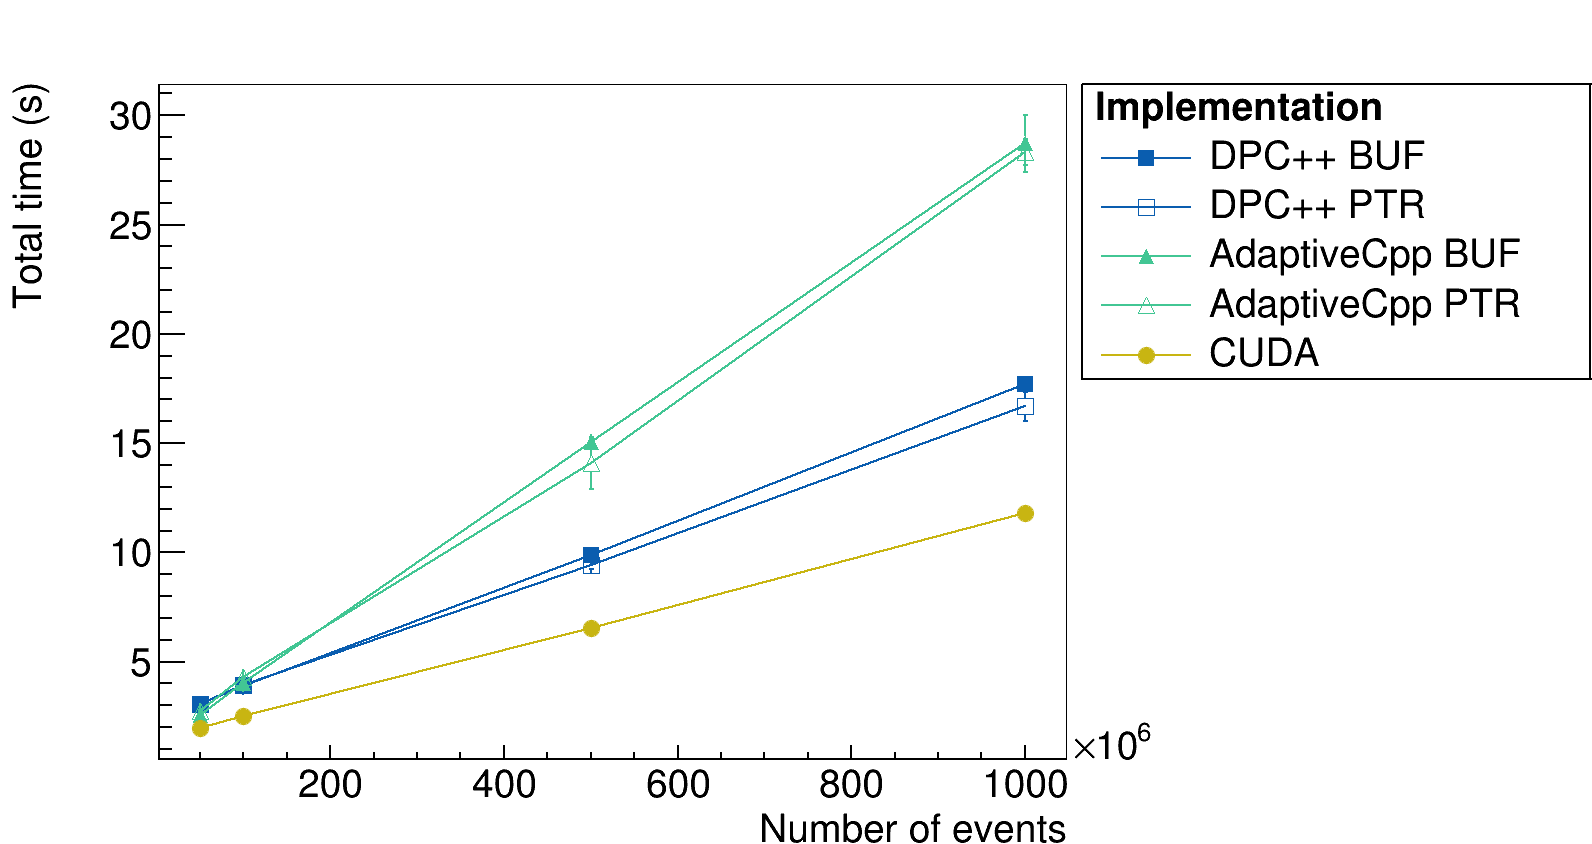

In [112]:
%jsroot off
title = f"Total Runtime of Histo1D with Different Input Sizes on NVIDIA A4000"

selected_env = unique_env
selected_bulksize = 32768
selected_type = unique_type
selected_bins = 1000
selected_nvals = unique_nvals
selected_gpu = "A4000"
selected_distr = "uniform"
selected_edges = True
selected_cc = 86
selected_red = 2

w = 1600
h = 900
c = ROOT.TCanvas("c1", "", w, h)

rmargin = 0.33
bmargin = 0
c.SetRightMargin(rmargin)
# c.SetBottomMargin(bmargin)
l = ROOT.TLegend(1.01-rmargin,0.55, 1, 0.9)
l.SetTextSize(0.05)
l.SetHeader("#bf{Implementation}")

mg = ROOT.TMultiGraph()

markerstyles = [21, 25, 22, 26, 20, 20]
versions = [
            ["DPC++", "Buffers"],
            ["DPC++", "USM"], 
            ["AdaptiveCpp", "Buffers"],
            ["AdaptiveCpp", "USM"], 
            ["CUDA", "Buffers"]
]
ROOT.gStyle.SetPalette(ROOT.kRainbow)  
for ei, (env, typ) in enumerate(versions):
    avg = np.array(gp.mean().loc[env, selected_gpu, selected_cc, typ, selected_distr, :, 
           selected_bins, selected_bulksize, selected_edges, selected_red]["ttotal"], dtype=np.float64)
    std = np.array(gp.std().loc[env, selected_gpu, selected_cc, typ, selected_distr, :, 
           selected_bins, selected_bulksize, selected_edges, selected_red]["ttotal"], dtype=np.float64)
    gr = ROOT.TGraphErrors(len(selected_nvals), selected_nvals.astype(np.float64), avg, 
                           np.repeat(0., len(selected_nvals)), std)

    color = ROOT.TColor.GetPalette()[50+ 60 * int(ei/2)]
    gr.SetMarkerColor(color)
    gr.SetLineColor(color)
    gr.SetLineWidth(2)
    gr.SetMarkerSize(2)
    gr.SetMarkerStyle(markerstyles[ei])
    
    gr.GetHistogram().SetMinimum(0)
    gr.GetHistogram().SetLineWidth(10)

    mg.Add(gr, "ALP ")
    l.AddEntry(gr, env.split("_")[0] + " " + (map_type(typ) if "CUDA" not in env else ""))

# gr = ROOT.TGraphErrors(len(selected_nvals), selected_nvals.astype(np.float64), 
#                         np.array(gp_cpu.mean().loc["CPU", selected_bins, 32768, selected_edges, :,selected_distr]["ttotal"], dtype=np.float64), 
#                         np.repeat(0., len(selected_nvals)),
#                         np.array(gp_cpu.std().loc["CPU", selected_bins, 32768, selected_edges, :, selected_distr]["ttotal"], dtype=np.float64))
# gr.SetMarkerColor(ROOT.kBlack)
# gr.SetLineColor(ROOT.kBlack)
# gr.SetLineWidth(2)
# gr.SetMarkerSize(2)
# gr.GetHistogram().SetMinimum(0)
# gr.GetHistogram().SetLineWidth(10)
# mg.Add(gr, "ALP ")
# l.AddEntry(gr, "CPU")
# mg.SetTitle(title)

xaxis = mg.GetXaxis()
# xaxis.SetTitle("#splitline{Bulk Size}")
xaxis.SetTitle("Number of events")
# xaxis.SetRangeUser(0, 10000000)
# xaxis.SetTitleOffset(1.5)
xaxis.SetTitleSize(0.05)
xaxis.SetLabelSize(0.05)
# xaxis.LabelsOption("hM")
# xaxis.SetTickSize(0)

yaxis = mg.GetYaxis()
yaxis.SetTitle("Total time (s)")
yaxis.SetTitleOffset(1)
yaxis.SetTitleSize(0.05)
yaxis.SetLabelSize(0.05)

ROOT.gStyle.SetTitleFontSize(0.1)

mg.Draw("a")
l.Draw()
c.SaveAs(f"../../images/sycl_totalruntime.pdf")
c.DrawClone()

In [113]:
# %jsroot off

# selected_env = unique_env
# selected_bulksize = 32768
# selected_type = unique_type
# selected_bins = 10
# selected_nvals = unique_nvals
# selected_gpu = "A4000"
# selected_distr = "uniform"
# selected_edges = True
# selected_cc = 86
# selected_red = 8

# title = f"Total Runtime of Histo1D with {selected_bins} bins on NVIDIA A4000"
# w = 1600
# h = 900
# c = ROOT.TCanvas("c1", "", w, h)

# rmargin = 0.33
# bmargin = 0
# c.SetRightMargin(rmargin)
# # c.SetBottomMargin(bmargin)
# l = ROOT.TLegend(1.01-rmargin,0.55, 1, 0.9)
# l.SetTextSize(0.05)
# l.SetHeader("#bf{Implementation}")

# mg = ROOT.TMultiGraph()

# markerstyles = [21, 25, 22, 26, 20, 20]
# versions = [
#             ["DPC++", "USM"], 
#             ["AdaptiveCpp", "USM"], 
#             ["CUDA", "Buffers"]
# ]
# ROOT.gStyle.SetPalette(ROOT.kRainbow)  
# for ei, (env, typ) in enumerate(versions):
#     avg = np.array(gp.mean().loc[env, selected_gpu, selected_cc, typ, selected_distr, :, 
#            selected_bins, selected_bulksize, selected_edges, selected_red]["ttotal"], dtype=np.float64)
#     std = np.array(gp.std().loc[env, selected_gpu, selected_cc, typ, selected_distr, :, 
#            selected_bins, selected_bulksize, selected_edges, selected_red]["ttotal"], dtype=np.float64)
#     gr = ROOT.TGraphErrors(len(selected_nvals), selected_nvals.astype(np.float64), avg, 
#                            np.repeat(0., len(selected_nvals)), std)

#     color = ROOT.TColor.GetPalette()[50+ 60 * int(ei)]
#     gr.SetMarkerColor(color)
#     gr.SetLineColor(color)
#     gr.SetLineWidth(2)
#     gr.SetMarkerSize(2)
#     gr.SetMarkerStyle(markerstyles[ei])
    
#     gr.GetHistogram().SetMinimum(0)
#     gr.GetHistogram().SetLineWidth(10)

#     mg.Add(gr, "ALP ")
#     l.AddEntry(gr, env.split("_")[0])

# gr = ROOT.TGraphErrors(len(selected_nvals), selected_nvals.astype(np.float64), 
#                         np.array(gp_cpu.mean().loc["CPU", selected_bins, 32768, selected_edges, :,selected_distr]["ttotal"], dtype=np.float64), 
#                         np.repeat(0., len(selected_nvals)),
#                         np.array(gp_cpu.std().loc["CPU", selected_bins, 32768, selected_edges, :, selected_distr]["ttotal"], dtype=np.float64))
# gr.SetMarkerColor(ROOT.kBlack)
# gr.SetLineColor(ROOT.kBlack)
# gr.SetLineWidth(2)
# gr.SetMarkerSize(2)
# gr.GetHistogram().SetMinimum(0)
# gr.GetHistogram().SetLineWidth(10)
# mg.Add(gr, "ALP ")
# l.AddEntry(gr, "CPU")
# mg.SetTitle(title)

# xaxis = mg.GetXaxis()
# # xaxis.SetTitle("#splitline{Bulk Size}")
# xaxis.SetTitle("Number of events")
# # xaxis.SetRangeUser(0, 10000000)
# # xaxis.SetTitleOffset(1.5)
# xaxis.SetTitleSize(0.05)
# xaxis.SetLabelSize(0.05)
# # xaxis.LabelsOption("hM")
# # xaxis.SetTickSize(0)

# yaxis = mg.GetYaxis()
# yaxis.SetTitle("Total time (s)")
# yaxis.SetTitleOffset(1)
# yaxis.SetTitleSize(0.05)
# yaxis.SetLabelSize(0.05)

# ROOT.gStyle.SetTitleFontSize(0.1)

# mg.Draw("a")
# l.Draw()
# # c.SaveAs(f"../../images/sycl_totalruntime.pdf")
# c.SaveAs(f"../../images/plot{selected_bins}_{selected_edges}.png")
# c.DrawClone()

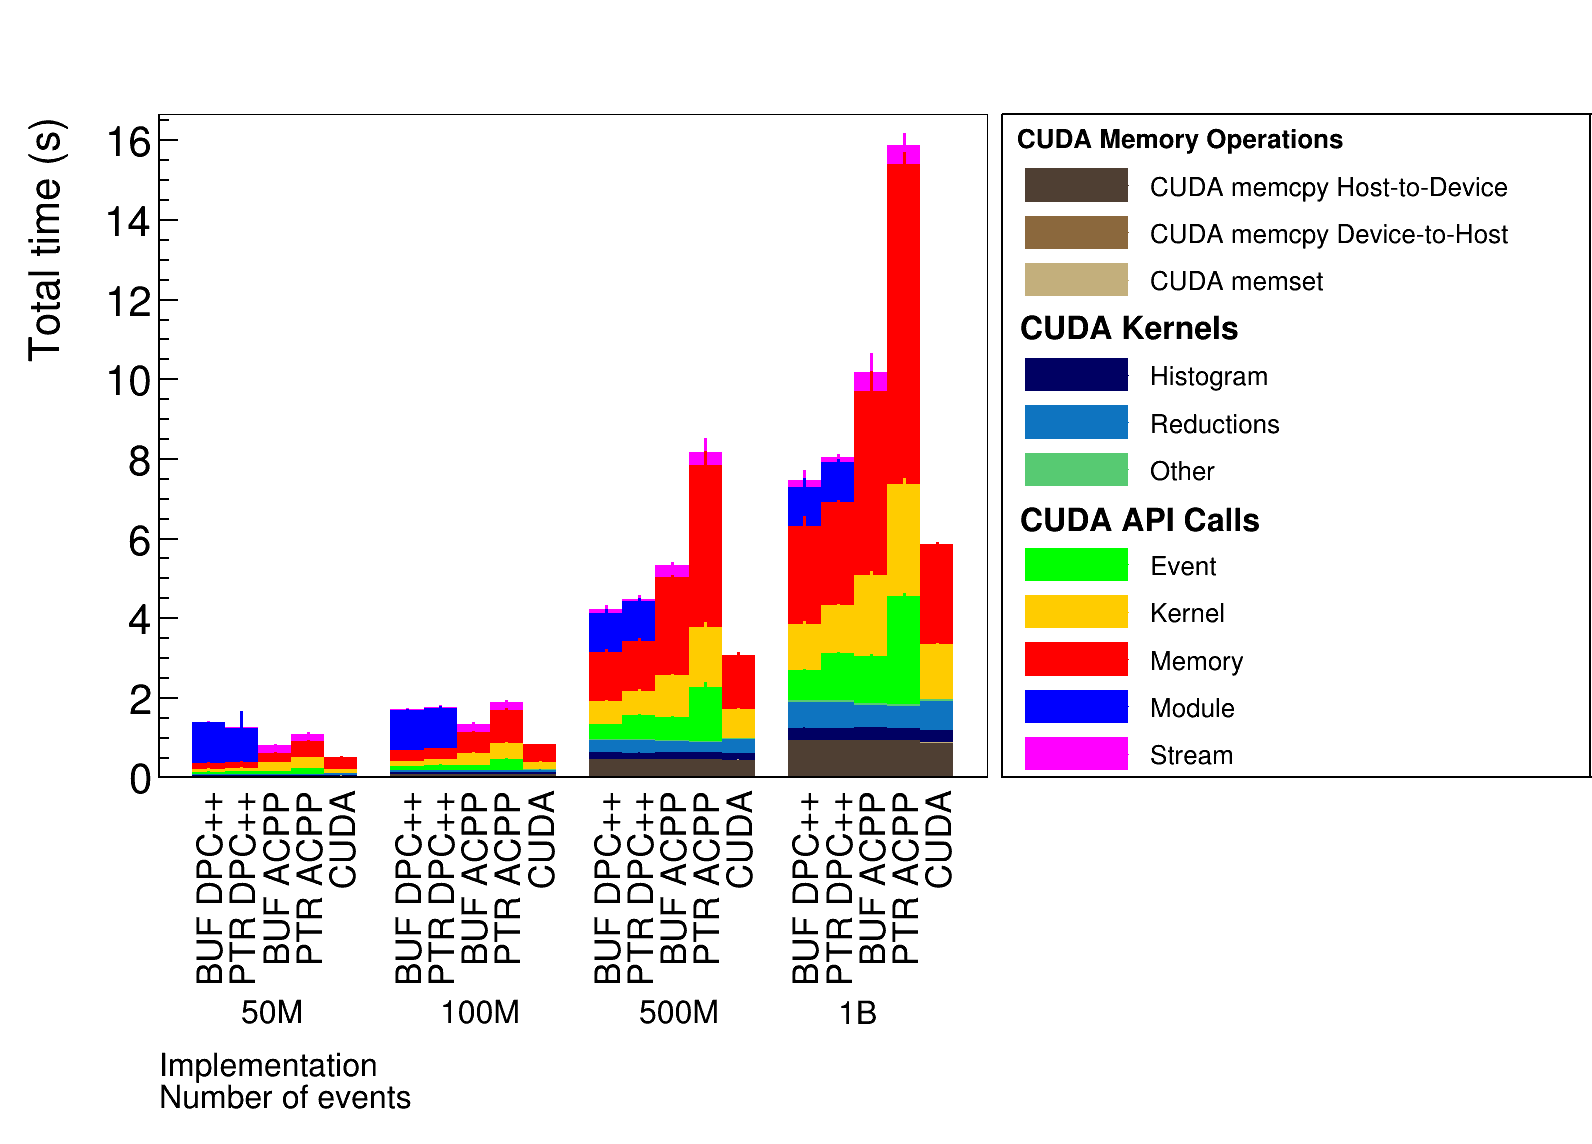

In [123]:
%jsroot off

selected_env = unique_env
selected_bulksize = 32768
selected_type = unique_type
selected_bins = 1000
selected_nvals = unique_nvals
selected_gpu = "A4000"
selected_distr = "uniform"
selected_edges = True
selected_cc = 86
selected_red = 2

nbins = 25
title = f"" 
ROOT.gStyle.SetErrorX(0.);    

w = 1600
h = 1200
c = ROOT.TCanvas("c1", title, w, h)
c.SetBottomMargin(0.6)

hs = ROOT.THStack("hs212", "")
rmargin = 0.38
bmargin = 0.32
c.SetRightMargin(rmargin)
c.SetBottomMargin(bmargin)
l = ROOT.TLegend(1.01-rmargin,bmargin, 1, 0.9)
l.SetHeader("#bf{CUDA Memory Operations}")
l.SetTextSize(0.025)

unique_labels = []
unique_colors = []
versions = [
            ["DPC++", "Buffers"],
            ["DPC++", "USM"], 
            ["AdaptiveCpp", "Buffers"],
            ["AdaptiveCpp", "USM"], 
            ["CUDA", "Buffers"]
]
for ei, (env, typ) in enumerate(versions):
    for nvi, nv in enumerate(selected_nvals):
        bin =  1 + nvi * 6 + ei
        arg = (env, selected_gpu, selected_cc, 
               typ, selected_distr, nv, selected_bins, 
               selected_bulksize, selected_edges, selected_red)
        
        ROOT.gStyle.SetPalette(ROOT.kCoffee)
        for mi, memop in enumerate(memops_names):
            memop_avg = gp_memops.mean().loc[arg]
            memop_std = gp_memops.std().loc[arg]
    
            if len(memop_avg) == 0 or memop not in memop_avg.index:
                continue
            # print(env, typ, bin, get_cell(memop_avg, memop, "Time"))
    
            h1 = ROOT.TH1F(f"{env}_{typ}_{nv}_{memop}", "gpu", nbins, 0, nbins)
            fill_bar(
                h1,
                bin,
                get_cell(memop_avg, memop, "Time"),
                get_cell(memop_std, memop, "Time"),
                ROOT.TColor.GetPalette()[100 * mi],
                gpuFillStyle[env],
            )
            hs.Add(h1)
            if memop not in unique_labels:
                # l.AddEntry(h1, memop.strip("CUDA ").title())
                unique_labels.append(memop)
                unique_colors.append(ROOT.TColor.GetPalette()[100 * mi])

        if ei == 0 and nvi == 0:
            # l.AddEntry(ROOT.kNone, "", "")
            unique_labels.append(None)
            unique_colors.append(None)
    
        ROOT.gStyle.SetPalette(ROOT.kRainbow)
        for ni, name in enumerate(kernel_names):
            kernel_avg = gp_kernels.mean().loc[arg]
            kernel_std = gp_kernels.std().loc[arg]

            if len(kernel_avg) == 0 or name not in kernel_avg.index:
                continue
                
            h2 = ROOT.TH1F(f"{env}_{typ}_{nv}_{name}", "gpu", nbins, 0, nbins)
            fill_bar(
                h2,
                bin,
                get_cell(kernel_avg, name, "Time"),
                get_cell(kernel_std, name, "Time"),
                ROOT.TColor.GetPalette()[60 * ni],
                gpuFillStyle[env],
            )
            hs.Add(h2)
            if name not in unique_labels:
                # l.AddEntry(h2, name)
                unique_labels.append(name)
                unique_colors.append(ROOT.TColor.GetPalette()[60 * ni])

        if ei == 0 and nvi == 0: 
        #     l.AddEntry(ROOT.kNone, "", "")
            unique_labels.append(None)
            unique_colors.append(None)

        # for ni, name in enumerate(np.sort(api_filtered_names)):
        for ni, name in enumerate([
             'Event', 
             'Kernel', 
             'Memory', 
             'Module',
             'Stream', 
             # 'Properties', 
        ]):
            api_avg = gp_api_filtered.mean().loc[arg]
            api_std = gp_api_filtered.std().loc[arg]
            if len(api_avg) == 0 or name not in api_avg.index:
                continue
            # if get_cell(api_avg, name, "Time (%)") == 0:
            #     continue
                
            val_mean = get_cell(api_avg, name, "Time") 
            val_std = get_cell(api_std, name, "Time") 
            v = (val_mean, val_std)
            
            color = get_group_color(name)
            h3 = ROOT.TH1F(f"{env}_{typ}_{nv}_{name}", "gpu", nbins, 0, nbins)
            fill_bar(
                h3,
                bin,
                v[0],
                v[1],
                color,
                gpuFillStyle[env],
            )
            # print(v)
            h3.SetLineWidth(3)
            hs.Add(h3)
            if name not in unique_labels:
                # l.AddEntry(h3, name)
                unique_labels.append(name)
                unique_colors.append(color)

# Manual labels in legend to have solid colors insteasd of with hatches 
for i, (lbl, clr) in enumerate(zip(unique_labels, unique_colors)):
    if lbl:
        hdummy = ROOT.TH1F(f"dummy_{lbl}", "dummy",  nbins, 0, nbins)
        hdummy.SetFillColor(clr)
        hdummy.SetLineColor(clr)
        hdummy.SetMarkerSize(0)
        hs.Add(hdummy)
        l.AddEntry(hdummy, lbl)
    else:
        hdummy = ROOT.TH1F(f"dummy_empty_{i}", "",  nbins, 0, nbins)
        hdummy.SetFillColor(ROOT.kWhite)
        hdummy.SetLineColor(ROOT.kWhite)
        hdummy.SetMarkerSize(0)
        hs.Add(hdummy)
        l.AddEntry(hdummy, f"")

hs.SetTitle(title)
hs.Draw("bar F")

xtoffset=-7.5
xtitle = ROOT.TLatex(0, xtoffset, "Implementation");
xtitle.Draw();
xtitle.SetTextSize(0.03)
xsubtitle = ROOT.TLatex(0, xtoffset-0.8, "Number of events");
xsubtitle.Draw();
xsubtitle.SetTextSize(0.03)

# Top x-axis labels
xaxis = hs.GetXaxis()
def map_env(e):
    if e == "CUDA_HIST":
        return "CUDA"
    elif e == "AdaptiveCpp": 
        return "ACPP"
    return e
for i, e in enumerate(range(2, nbins, 6)):
    for ei, (env, typ) in enumerate(versions):
        xaxis.SetBinLabel(e + ei, f"{(map_type(typ) if 'CUDA' not in env else '')} {map_env(env)}")
        # xaxis.SetBinLabel(e + ei, f"")
xaxis.SetTitleOffset(3)
xaxis.SetTitleSize(0.05)
xaxis.LabelsOption("vM")
xaxis.SetLabelSize(0.05)
xaxis.SetTickSize(0)

# Bottom x-axis labels
ox = ROOT.TGaxis(
    0,
    0,  # xmin, ymin
    nbins,
    0,  # xmax, ymax
    0,
    nbins,  # wmin, wmax
    nbins,
    "S hM",  # ndiv, chopts
)
ox.SetTickSize(0)
ox.SetLabelOffset(0.18)
ox.SetLabelFont(42)
ox.SetLabelSize(0.03)

labelbins = range(3, nbins + 1, 6)
for i in range(nbins + 2):
    if i not in labelbins:
        ox.ChangeLabel(i, -1, 0.0)
for i, e  in enumerate(labelbins):
    ox.ChangeLabel(e, 0, -1, 12, -1, -1, human_readable(selected_nvals[i]))

ox.Draw()

yaxis = hs.GetYaxis()
yaxis.SetTitle("Total time (s)")
yaxis.SetTitleSize(0.04)
yaxis.SetLabelSize(0.04)

ROOT.gStyle.SetTitleFontSize(0.1)

l.Draw()
h3posy = 6.2
legendheader2 = ROOT.TLatex(26, h3posy + 4.8, "#bf{CUDA Kernels}");
legendheader2.SetTextSize(0.03)
legendheader2.Draw();
legendheader3 = ROOT.TLatex(26, h3posy, "#bf{CUDA API Calls}");
legendheader3.SetTextSize(0.03)
legendheader3.Draw();

ROOT.gPad.Update()
c.SaveAs(f"../../images/nsys_buf_vs_ptr.pdf")
c.DrawClone()

In [115]:
api_filtered_names

array(['Kernel', 'Stream', 'Memory', 'Event', 'Properties', 'Module'],
      dtype=object)

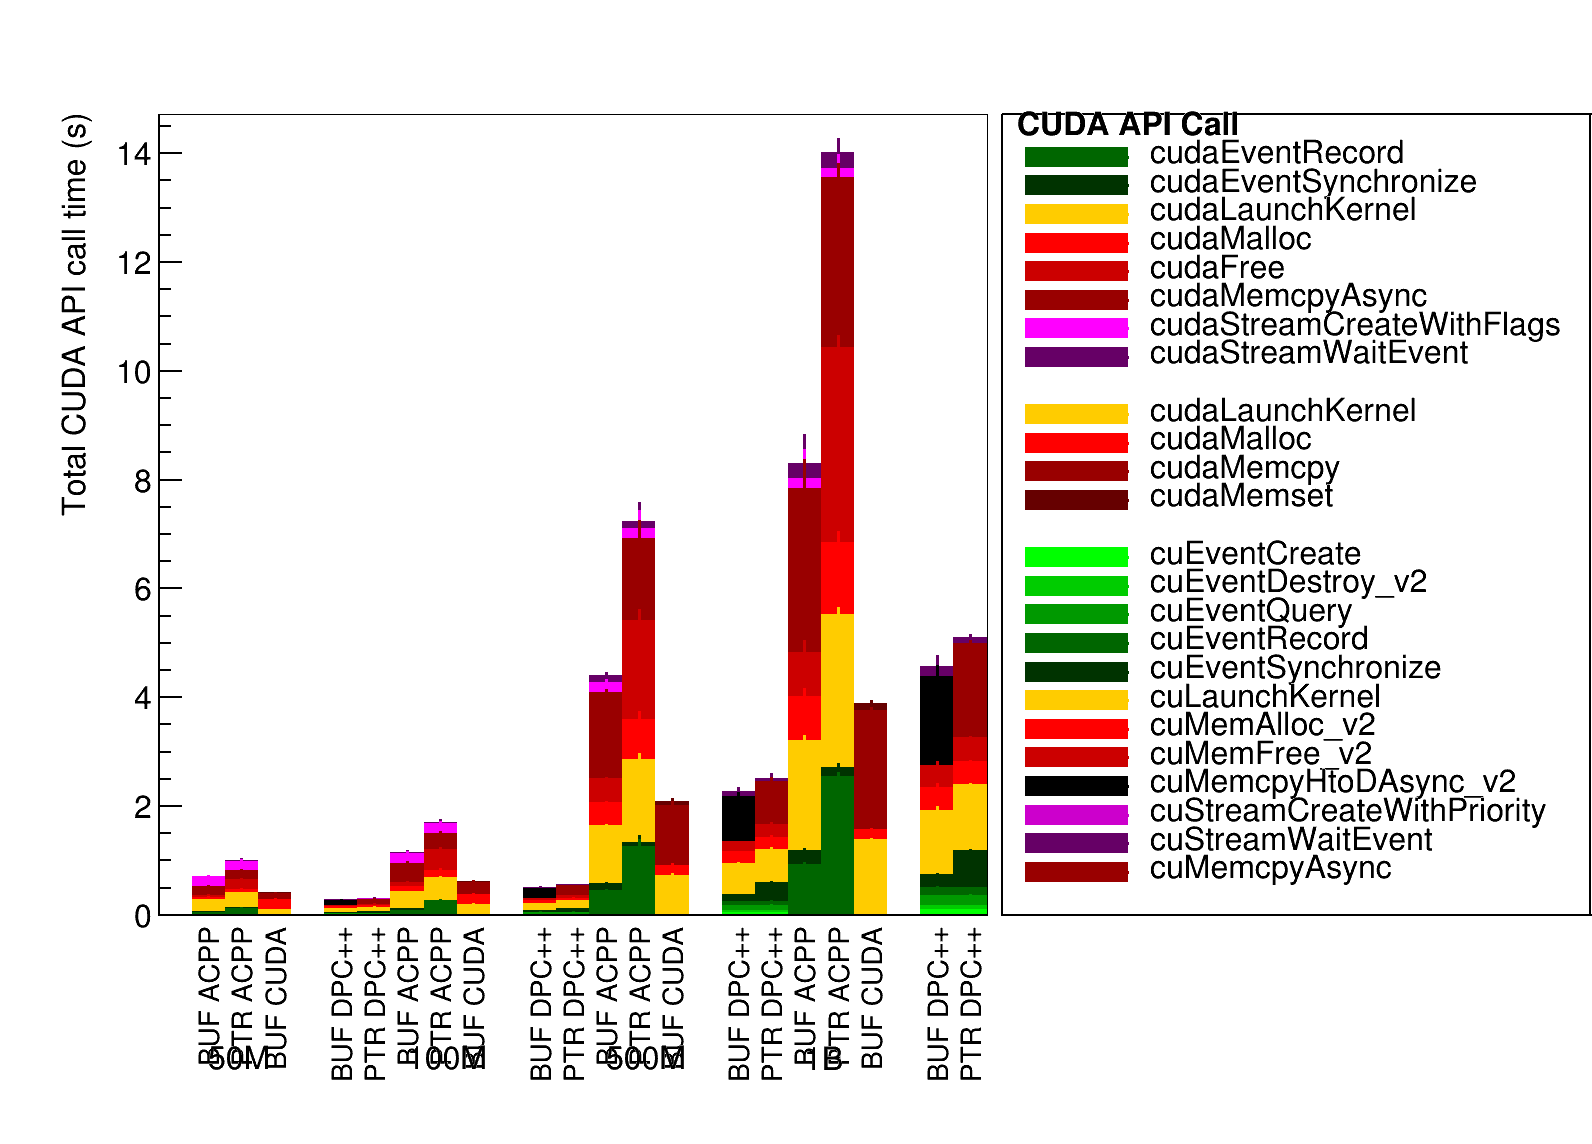

In [116]:
%jsroot off
selected_env = unique_env
selected_bulksize = 32768
selected_type = unique_type
selected_bins = 1000
selected_nvals = unique_nvals
selected_gpu = "A4000"
selected_distr = "uniform"
selected_edges = True
selected_cc = 86
selected_red = 2

# nbins = len(selected_env) * len(selected_nvals) + len(selected_nvals) + 1
nbins = 1 + 6 * 4
title = f""
# title = f"Nsys profiling results for time spent on GPU when filling a 1D histogram with RDataFrame"
ROOT.gStyle.SetErrorX(0.);    

w = 1600
h = 1200
c = ROOT.TCanvas("c1", title, w, h)

hs = ROOT.THStack("h1s", "")
rmargin = 0.38
bmargin = 0.2
c.SetRightMargin(rmargin)
c.SetBottomMargin(bmargin)
l = ROOT.TLegend(1.01-rmargin,bmargin, 1, 0.9)
l.SetHeader("#bf{CUDA API Call}")

# l = ROOT.TLegend()
l.SetTextSize(0.03)

for ei, env in enumerate(selected_env):    
    unique_labels = []
    for ti, typ in enumerate(selected_type):    
        tti = ti
        if "CUDA" in env:
            tti = 0    
            if typ == "USM":
                continue
            
        for nvi, nv in enumerate(selected_nvals): 
            bin = 1 + nvi * 6 + ei * 2 + tti
            for ni, name in enumerate((np.sort(api_names) if "AdaptiveCpp" != env else [
            'cudaEventRecord',
            'cudaEventSynchronize',
            'cudaLaunchKernel',
            'cudaMalloc',
            'cudaFree',
            'cudaMemcpyAsync',
            'cudaStreamCreateWithFlags',
            'cudaStreamWaitEvent',
            ])):            
                if len(unique_labels) >-1:
                    arg = (env, selected_gpu, selected_cc,
                           typ, selected_distr, nv, selected_bins, 
                           selected_bulksize, selected_edges, selected_red)
                    api_avg = gp_api.mean().loc[arg]
                    api_std = gp_api.std().loc[arg]
    
                    if "Module" in name:
                        continue
                    if len(api_avg) == 0 or name not in api_avg.index:
                        continue
                    if get_cell(api_avg, name, "Time (%)") <= 0.1:
                        continue
                        
                    val = get_cell(api_avg, name, "Time") 
                    color = get_color(name, unique_labels)
                    if not color:
                        color=ROOT.kBlack
                    h3 = ROOT.TH1F(f"{env}_{nv}_{name}", "gpu", nbins, 0, nbins)
                    fill_bar(
                        h3,
                        bin,
                        val,
                        get_cell(api_std, name, "Time"),
                        color,
                        None,
                    )
                    h3.SetLineWidth(3)
                    hs.Add(h3)
                    if name not in unique_labels:
                        # if val > 1: 
                        #     l.AddEntry(h3, name)
                        # else:
                            # l.AddEntry(h3, "Other")
                        l.AddEntry(h3, name)
                        unique_labels.append(name)
    l.AddEntry(ROOT.kNone, "", "")

hs.Draw("bar")

hs.SetTitle(title)
# hs.SetMaximum(120)

xtoffset=-8.5
xtitle = ROOT.TLatex(0, xtoffset, "Implementation");
xtitle.Draw();
xtitle.SetTextSize(0.03)
xsubtitle = ROOT.TLatex(0, xtoffset-0.8, "Number of events");
xsubtitle.Draw();
xsubtitle.SetTextSize(0.03)


xaxis = hs.GetXaxis()
xaxis.SetTitle("")
# xaxis.SetTitle("Bulk size")
xaxis.SetTitleOffset(2.5)

def map_env(e):
    if e == "CUDA_HIST":
        return "CUDA"
    elif e == "AdaptiveCpp": 
        return "ACPP"
    return e
for i, e in enumerate(range(2, nbins, 6)):
    for ei, env in enumerate(selected_env):
        for ti, typ in enumerate(selected_type):
            if "CUDA" in env and typ == "USM":
                continue
            xaxis.SetBinLabel(e + ei*2 + ti, f"{map_type(typ)} {map_env(env)}")
        # xaxis.SetBinLabel(e + ei, f"")
xaxis.LabelsOption("vM")
xaxis.SetTickSize(0)
xaxis.SetTitleSize(0.03)
xaxis.SetLabelSize(0.04)

ox = ROOT.TGaxis(
    0,
    0,  # xmin, ymin
    nbins,
    0,  # xmax, ymax
    0,
    nbins,  # wmin, wmax
    nbins,
    "SM",  # ndiv, chopt
)
ox.SetTickSize(0)
ox.SetLabelOffset(0.1)
ox.SetLabelFont(42)
ox.SetLabelSize(0.03)

labelbins = range(2, nbins + 1, 6)
for i in range(nbins + 3):
    if i not in labelbins:
        ox.ChangeLabel(i, -1, 0.0)
for i, e  in enumerate(labelbins):
    ox.ChangeLabel(e, 0, -1, 12, -1, -1, human_readable(selected_nvals[i]))

ox.Draw()

yaxis = hs.GetYaxis()
yaxis.SetTitle("Total CUDA API call time (s)")
yaxis.SetTitleSize(0.03)
yaxis.SetLabelSize(0.03)
yaxis.SetRangeUser(0,18)
# c.SetLogy()
# hs.SetMaximum(19);

ROOT.gStyle.SetTitleFontSize(0.1)

l.Draw()
# c.SaveAs(f"../../images/dpcpp_aot_vs_jit.pdf")
c.DrawClone()

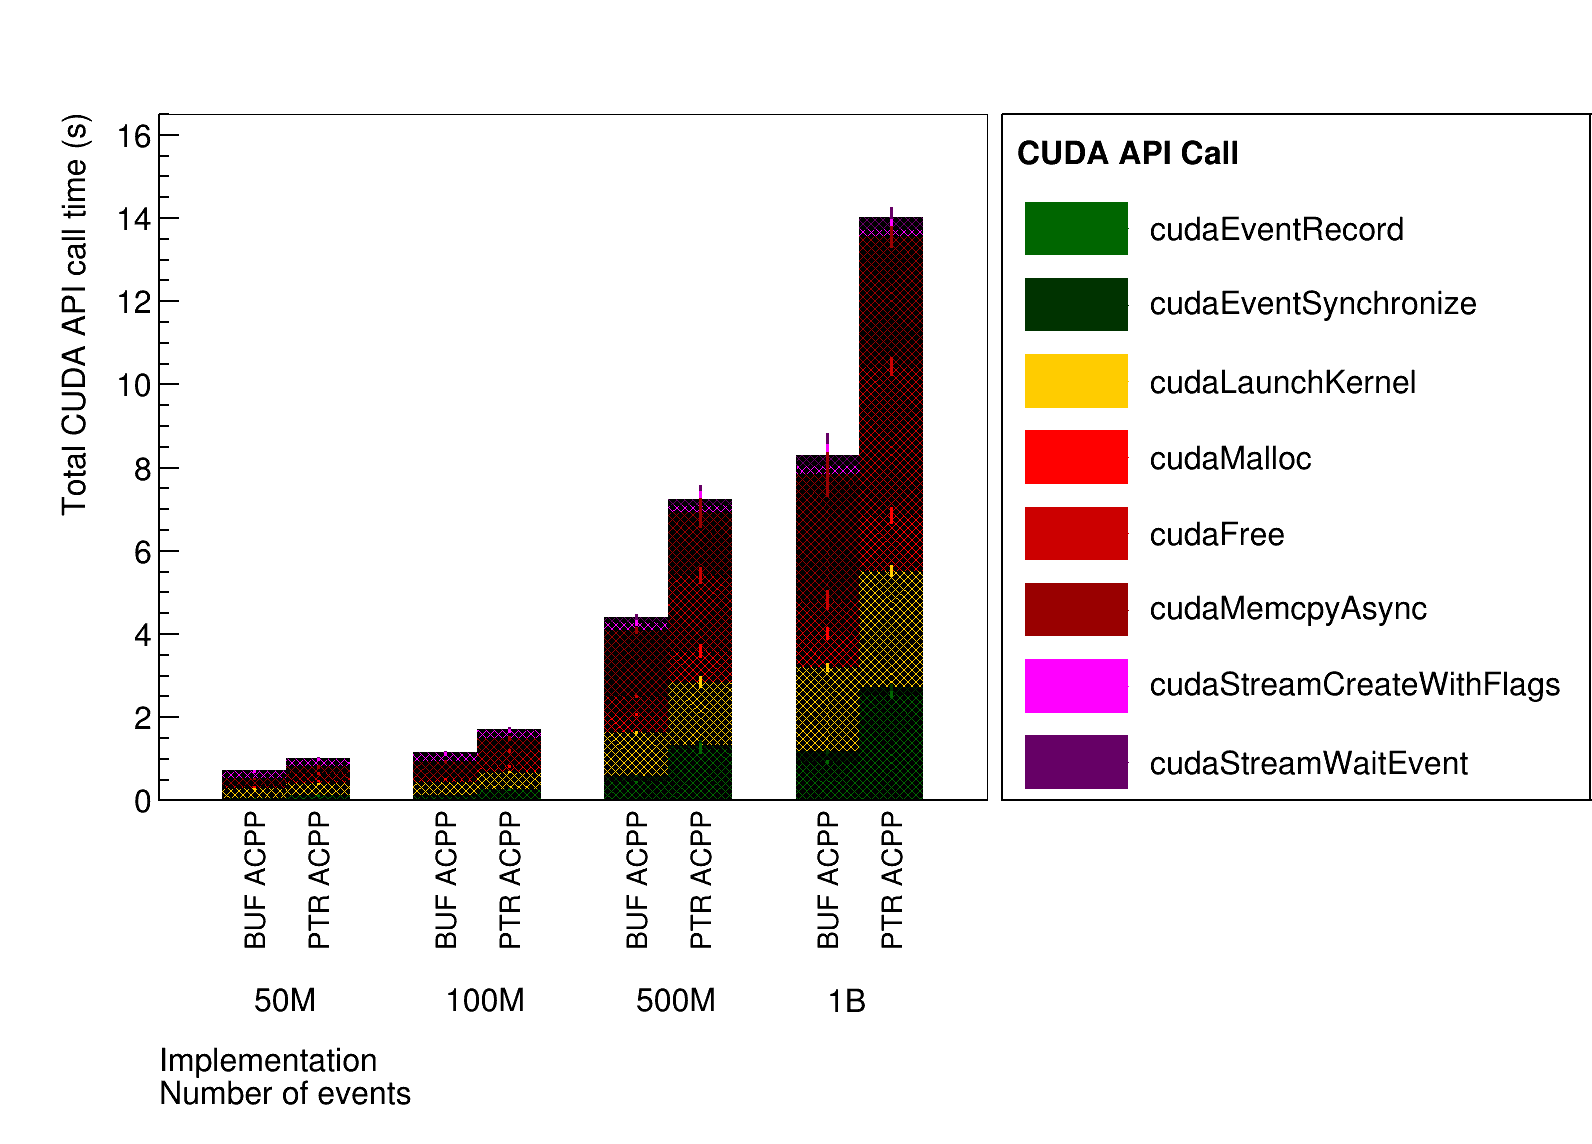

In [117]:
#### %jsroot off
selected_env = ["AdaptiveCpp"]
selected_bulksize = 32768
selected_type = unique_type
selected_bins = 1000
selected_nvals = unique_nvals
selected_gpu = "A4000"
selected_distr = "uniform"
selected_edges = True
selected_cc = 86
selected_red = 2

# nbins = len(selected_env) * len(selected_nvals) + len(selected_nvals) + 1
nbins = 1 + 3 * 4
title = f""
# title = f"Nsys profiling results for time spent on GPU when filling a 1D histogram with RDataFrame"
ROOT.gStyle.SetErrorX(0.);    

w = 1600
h = 1200
c = ROOT.TCanvas("c1", title, w, h)

hs = ROOT.THStack("h1s", "")
rmargin = 0.38
bmargin = 0.3
c.SetRightMargin(rmargin)
c.SetBottomMargin(bmargin)
l = ROOT.TLegend(1.01-rmargin,bmargin, 1, 0.9)
l.SetHeader("#bf{CUDA API Call}")

# l = ROOT.TLegend()
l.SetTextSize(0.03)

for ei, env in enumerate(selected_env):    
    unique_labels = []
    if env == "DPC++":
        nms = [
           "cuEventCreate",
           "cuEventDestroy_v2",
           "cuEventQuery",
           "cuEventRecord",
           "cuEventSynchronize",
           "cuLaunchKernel",
           "cuMemAlloc_v2",
           "cuMemFree_v2",
           "cuMemcpyAsync",
           "cuMemcpyHtoDAsync_v2",
           "cuStreamCreateWithPriority",
           "cuStreamDestroy_v2",
           "cuStreamWaitEvent",
    ]
    elif env == "AdaptiveCpp":
        nms = [
            'cudaEventRecord',
            'cudaEventSynchronize',
            'cudaLaunchKernel',
            'cudaMalloc',
            'cudaFree',
            'cudaMemcpyAsync',
            'cudaStreamCreateWithFlags',
            'cudaStreamWaitEvent',
        ]
    else:
        nms = np.sort(api_names)
    # nms = np.sort(api_names)

    for ti, typ in enumerate(selected_type):    
        tti = ti
        if "CUDA" in env:
            tti = 0    
            if typ == "Buffers":
                continue
            
        for nvi, nv in enumerate(selected_nvals): 
            bin = 1 + nvi * (len(selected_env) + len(selected_type)) + ei * len(selected_type) + tti
                
            for ni, name in enumerate(nms):
                arg = (env, selected_gpu, selected_cc,
                       typ, selected_distr, nv, selected_bins, 
                       selected_bulksize, selected_edges, selected_red)
                api_avg = gp_api.mean().loc[arg]
                api_std = gp_api.std().loc[arg]

                if len(api_avg) == 0 or name not in api_avg.index:
                    continue
                if get_cell(api_avg, name, "Time (%)") < 0.1:
                    continue
                    
                val = get_cell(api_avg, name, "Time") 
                color = get_color(name)
                if not color:
                    color=ROOT.kBlack
                h3 = ROOT.TH1F(f"{env}_{nv}_{name}", "gpu", nbins, 0, nbins)
                fill_bar(
                    h3,
                    bin,
                    val,
                    get_cell(api_std, name, "Time"),
                    color,
                    gpuFillStyle[env],
                )
                h3.SetLineWidth(3)
                hs.Add(h3)
                if name not in unique_labels:
                    unique_labels.append(name)
                    
    # l.AddEntry(ROOT.kNone, "", "")
    for lbl in nms:
        hdummy = ROOT.TH1F(f"dummy_{lbl}", "dummy", nbins, 0, nbins) 
        color = get_color(lbl)
        if not color:
            color=ROOT.kBlack
        hdummy.SetFillColor(color)
        hdummy.SetLineColor(color)
        hdummy.SetMarkerSize(0)
        hs.Add(hdummy)
        l.AddEntry(hdummy, lbl)

hs.Draw("bar")

hs.SetTitle(title)
# hs.SetMaximum(120)

xtoffset=-6.5
xtitle = ROOT.TLatex(0, xtoffset, "Implementation");
xtitle.Draw();
xtitle.SetTextSize(0.03)
xsubtitle = ROOT.TLatex(0, xtoffset-0.8, "Number of events");
xsubtitle.Draw();
xsubtitle.SetTextSize(0.03)


xaxis = hs.GetXaxis()
xaxis.SetTitle("")
# xaxis.SetTitle("Bulk size")
xaxis.SetTitleOffset(2.5)

def map_env(e):
    if e == "CUDA_HIST":
        return "CUDA"
    elif e == "AdaptiveCpp": 
        return "ACPP"
    return e
for i, e in enumerate(range(2, nbins, 3)):
    for ei, env in enumerate(selected_env):
        for ti, typ in enumerate(selected_type):
            if "CUDA" in env and typ == "USM":
                continue
            xaxis.SetBinLabel(e + ei*2 + ti, f"{map_type(typ)} {map_env(env)}")
        # xaxis.SetBinLabel(e + ei, f"")
xaxis.LabelsOption("vM")
xaxis.SetTickSize(0)
xaxis.SetTitleSize(0.03)
xaxis.SetLabelSize(0.04)

ox = ROOT.TGaxis(
    0,
    0,  # xmin, ymin
    nbins,
    0,  # xmax, ymax
    0,
    nbins,  # wmin, wmax
    nbins,
    "S hM",  # ndiv, chopt
)
ox.SetTickSize(0)
ox.SetLabelOffset(0.15)
ox.SetLabelFont(42)
ox.SetLabelSize(0.03)

labelbins = range(2, nbins + 1, 3)
for i in range(nbins + 3):
    if i not in labelbins:
        ox.ChangeLabel(i, -1, 0.0)
for i, e  in enumerate(labelbins):
    ox.ChangeLabel(e, 0, -1, 12, -1, -1, human_readable(selected_nvals[i]))

ox.Draw()

yaxis = hs.GetYaxis()
yaxis.SetTitle("Total CUDA API call time (s)")
yaxis.SetTitleSize(0.03)
yaxis.SetLabelSize(0.03)
yaxis.SetRangeUser(0,18)
# c.SetLogy()
hs.SetMaximum(16.5);

ROOT.gStyle.SetTitleFontSize(0.1)

l.Draw()
c.SaveAs(f"../../images/acpp_buf_vs_ptr.pdf")
c.DrawClone()

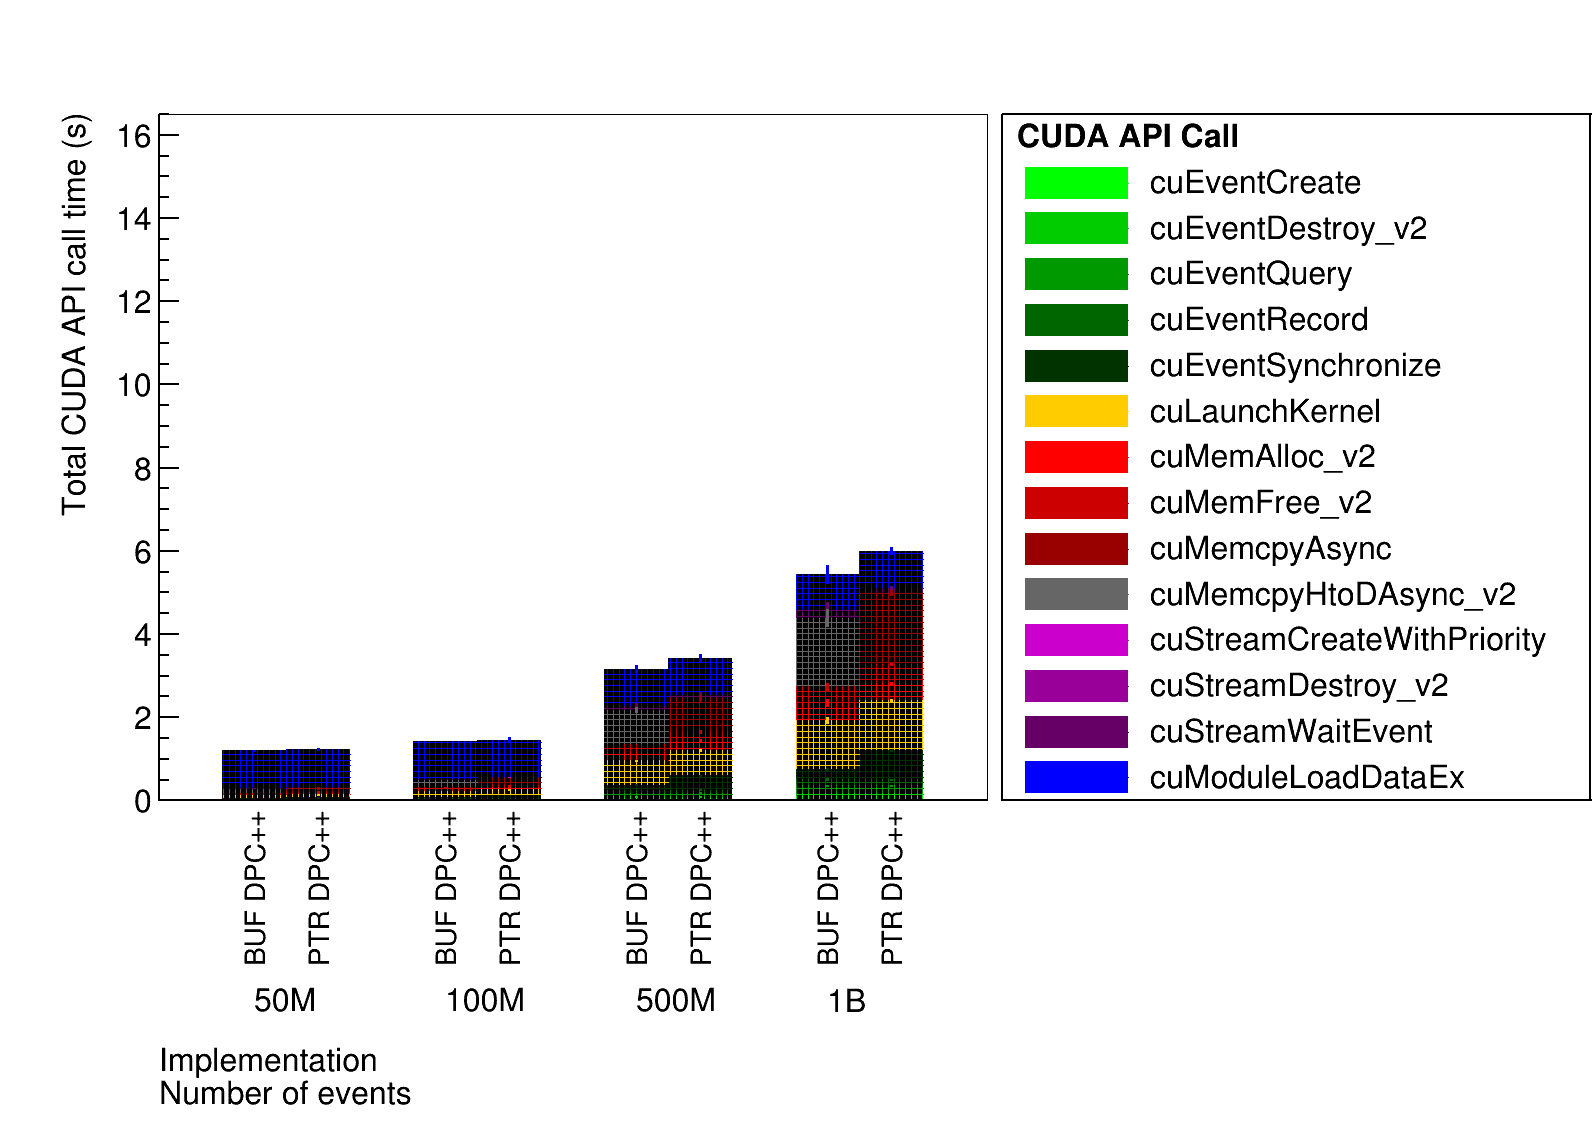

In [118]:
%jsroot off
selected_env = ["DPC++"]
selected_bulksize = 32768
selected_type = unique_type
selected_bins = 1000
selected_nvals = unique_nvals
selected_gpu = "A4000"
selected_distr = "uniform"
selected_edges = True
selected_cc = 86
selected_red = 2

# nbins = len(selected_env) * len(selected_nvals) + len(selected_nvals) + 1
nbins = 1 + 3 * 4
title = f""
# title = f"Nsys profiling results for time spent on GPU when filling a 1D histogram with RDataFrame"
ROOT.gStyle.SetErrorX(0.);    

w = 1600
h = 1200
c = ROOT.TCanvas("c1", title, w, h)

hs = ROOT.THStack("h1s", "")
rmargin = 0.38
bmargin = 0.3
c.SetRightMargin(rmargin)
c.SetBottomMargin(bmargin)
l = ROOT.TLegend(1.01-rmargin,bmargin, 1, 0.9)
l.SetHeader("#bf{CUDA API Call}")

# l = ROOT.TLegend()
l.SetTextSize(0.03)

for ei, env in enumerate(selected_env):    
    unique_labels = []
    if env == "DPC++":
        nms = [
           "cuEventCreate",
           "cuEventDestroy_v2",
           "cuEventQuery",
           "cuEventRecord",
           "cuEventSynchronize",
           "cuLaunchKernel",
           "cuMemAlloc_v2",
           "cuMemFree_v2",
           "cuMemcpyAsync",
           "cuMemcpyHtoDAsync_v2",
           "cuStreamCreateWithPriority",
           "cuStreamDestroy_v2",
           "cuStreamWaitEvent",
           "cuModuleLoadDataEx",
    ]
    elif env == "AdaptiveCpp":
        nms = [
            'cudaEventRecord',
            'cudaEventSynchronize',
            'cudaLaunchKernel',
            'cudaMalloc',
            'cudaFree',
            'cudaMemcpyAsync',
            'cudaStreamCreateWithFlags',
            'cudaStreamWaitEvent',
        ]
    else:
        nms = np.sort(api_names)
    # nms = np.sort(api_names)

    for ti, typ in enumerate(selected_type):    
        tti = ti
        if "CUDA" in env:
            tti = 0    
            if typ == "Buffers":
                continue
            
        for nvi, nv in enumerate(selected_nvals): 
            bin = 1 + nvi * (len(selected_env) + len(selected_type)) + ei * len(selected_type) + tti
                
            for ni, name in enumerate(nms):
                arg = (env, selected_gpu, selected_cc,
                       typ, selected_distr, nv, selected_bins, 
                       selected_bulksize, selected_edges, selected_red)
                api_avg = gp_api.mean().loc[arg]
                api_std = gp_api.std().loc[arg]

                if len(api_avg) == 0 or name not in api_avg.index:
                    continue
                if get_cell(api_avg, name, "Time (%)") <= 0.1:
                    continue
                    
                val = get_cell(api_avg, name, "Time") 
                color = get_color(name)
                if not color:
                    color=default_clr
                h3 = ROOT.TH1F(f"{env}_{nv}_{name}", "gpu", nbins, 0, nbins)
                fill_bar(
                    h3,
                    bin,
                    val,
                    get_cell(api_std, name, "Time"),
                    color,
                    gpuFillStyle[env],
                )
                h3.SetLineWidth(3)
                hs.Add(h3)
                if name not in unique_labels:
                    unique_labels.append(name)
                    
    # l.AddEntry(ROOT.kNone, "", "")
    for lbl in nms:
        hdummy = ROOT.TH1F(f"dummy_{lbl}", "dummy", nbins, 0, nbins) 
        color = get_color(lbl)
        if not color:
            color=default_clr
        hdummy.SetFillColor(color)
        hdummy.SetLineColor(color)
        hdummy.SetMarkerSize(0)
        hs.Add(hdummy)
        l.AddEntry(hdummy, lbl)

hs.Draw("bar")

hs.SetTitle(title)
# hs.SetMaximum(120)

xtoffset=-6.5
xtitle = ROOT.TLatex(0, xtoffset, "Implementation");
xtitle.Draw();
xtitle.SetTextSize(0.03)
xsubtitle = ROOT.TLatex(0, xtoffset-0.8, "Number of events");
xsubtitle.Draw();
xsubtitle.SetTextSize(0.03)


xaxis = hs.GetXaxis()
xaxis.SetTitle("")
# xaxis.SetTitle("Bulk size")
xaxis.SetTitleOffset(2.5)

def map_env(e):
    if e == "CUDA_HIST":
        return "CUDA"
    elif e == "AdaptiveCpp": 
        return "ACPP"
    return e
for i, e in enumerate(range(2, nbins, 3)):
    for ei, env in enumerate(selected_env):
        for ti, typ in enumerate(selected_type):
            if "CUDA" in env and typ == "USM":
                continue
            xaxis.SetBinLabel(e + ei*2 + ti, f"{map_type(typ)} {map_env(env)}")
        # xaxis.SetBinLabel(e + ei, f"")
xaxis.LabelsOption("vM")
xaxis.SetTickSize(0)
xaxis.SetTitleSize(0.03)
xaxis.SetLabelSize(0.04)

ox = ROOT.TGaxis(
    0,
    0,  # xmin, ymin
    nbins,
    0,  # xmax, ymax
    0,
    nbins,  # wmin, wmax
    nbins,
    "S hM",  # ndiv, chopt
)
ox.SetTickSize(0)
ox.SetLabelOffset(0.15)
ox.SetLabelFont(42)
ox.SetLabelSize(0.03)

labelbins = range(2, nbins + 1, 3)
for i in range(nbins + 3):
    if i not in labelbins:
        ox.ChangeLabel(i, -1, 0.0)
for i, e  in enumerate(labelbins):
    ox.ChangeLabel(e, 0, -1, 12, -1, -1, human_readable(selected_nvals[i]))

ox.Draw()

yaxis = hs.GetYaxis()
yaxis.SetTitle("Total CUDA API call time (s)")
yaxis.SetTitleSize(0.03)
yaxis.SetLabelSize(0.03)
yaxis.SetRangeUser(0,18)
# c.SetLogy()
hs.SetMaximum(16.5);

ROOT.gStyle.SetTitleFontSize(0.1)

l.Draw()
c.SaveAs(f"../../images/dpcpp_buf_vs_ptr.pdf")
c.DrawClone()

In [119]:
np.unique(nms)

array(['cuEventCreate', 'cuEventDestroy_v2', 'cuEventQuery',
       'cuEventRecord', 'cuEventSynchronize', 'cuLaunchKernel',
       'cuMemAlloc_v2', 'cuMemFree_v2', 'cuMemcpyAsync',
       'cuMemcpyHtoDAsync_v2', 'cuModuleLoadDataEx',
       'cuStreamCreateWithPriority', 'cuStreamDestroy_v2',
       'cuStreamWaitEvent'], dtype='<U26')

In [120]:
gp_api.mean().loc["AdaptiveCpp", "A4000", 86, "USM", "uniform", 1e9, 1000, 32768, True,8]

KeyError: ('AdaptiveCpp', 'A4000', 86, 'USM', 'uniform', 1000000000.0, 1000, 32768, True, 8)

In [ ]:
np.sort(api_names)[:3]

In [ ]:
%jsroot off
selected_env = "DPC++"
selected_bulksize = 32768
selected_type = "USM"
selected_bins = 1000
selected_nvals = unique_nvals
selected_gpu = "A4000"
selected_distr = "uniform"
selected_edges = True
selected_cc = [75,86]
selected_red = 8

# nbins = len(selected_env) * len(selected_nvals) + len(selected_nvals) + 1
nbins = 2 * len(selected_nvals) + 5
title = f""
# title = f"Nsys profiling results for time spent on GPU when filling a 1D histogram with RDataFrame"
ROOT.gStyle.SetErrorX(0.);    

w = 1600
h = 1200
c = ROOT.TCanvas("c1", title, w, h)

hs = ROOT.THStack("h1s", "")
rmargin = 0.38
bmargin = 0.15
c.SetRightMargin(rmargin)
c.SetBottomMargin(bmargin)
l = ROOT.TLegend(1.01-rmargin,bmargin, 1, 0.9)
l.SetHeader("#bf{CUDA API Call}")

# l = ROOT.TLegend()
l.SetTextSize(0.03)

unique_labels = []
for ci, cc in enumerate(selected_cc):    
    other = 0

    for ni, name in enumerate(np.sort(api_names)):
        bin = 1 + ci 
        for nvi, nv in enumerate(selected_nvals): 
            if len(unique_labels) >-1:
                arg = (selected_env, selected_gpu, cc,
                       selected_type, selected_distr, nv, selected_bins, 
                       selected_bulksize, selected_edges, selected_red)
                api_avg = gp_api.mean().loc[arg]
                api_std = gp_api.std().loc[arg]

                # if "Module" in name:
                #     continue
                if len(api_avg) == 0 or name not in api_avg.index:
                    continue
                if get_cell(api_avg, name, "Time (%)") == 0:
                    continue
                    
                val = get_cell(api_avg, name, "Time") 
                color = get_color(name, unique_labels)
                if not color:
                    color=ROOT.kBlack
                h3 = ROOT.TH1F(f"{cc}_{nv}_{name}", "gpu", nbins, 0, nbins)
                fill_bar(
                    h3,
                    bin,
                    val,
                    get_cell(api_std, name, "Time"),
                    color,
                    gpuFillStyle[env],
                )
                h3.SetLineWidth(3)
                hs.Add(h3)
                bin += 3
                if name not in unique_labels:
                    unique_labels.append(name)

nms=['cuEventCreate',
 'cuEventDestroy_v2',
 'cuEventQuery',
 'cuEventRecord',
 'cuEventSynchronize',
 'cuLaunchKernel',
 'cuMemAlloc_v2',
 'cuMemFree_v2',
 'cuMemcpyAsync',
 'cuModuleLoadDataEx',
 'cuModuleUnload',
 'cuStreamCreateWithPriority',
 'cuStreamDestroy_v2',
 'cuStreamWaitEvent',
]
assert(len(nms) == len(unique_labels))
for lbl in nms:
    hdummy = ROOT.TH1F(f"dummy_{lbl}", "dummy", nbins, 0, nbins) 
    color = get_color(lbl)
    if not color:
        color=ROOT.kBlack
    hdummy.SetFillColor(color)
    hdummy.SetLineColor(color)
    hdummy.SetMarkerSize(0)
    hs.Add(hdummy)
    l.AddEntry(hdummy, lbl)
        
hs.Draw("bar")

hs.SetTitle(title)
# hs.SetMaximum(120)

xtoffset=-20
xtitle = ROOT.TLatex(0, xtoffset, "Target compute capability");
xtitle.Draw();
xtitle.SetTextSize(0.03)
xsubtitle = ROOT.TLatex(0, xtoffset-7, "Number of events");
xsubtitle.Draw();
xsubtitle.SetTextSize(0.03)

xaxis = hs.GetXaxis()
xaxis.SetTitle("")
# xaxis.SetTitle("Bulk size")
xaxis.SetTitleOffset(2.5)

def map_env(e):
    if e == "CUDA_HIST":
        return "CUDA"
    elif e == "AdaptiveCpp": 
        return "ACPP"
    return e
for i, e in enumerate(range(2, nbins, 3)):
    for ei, typ in enumerate(selected_cc):
        xaxis.SetBinLabel(e + ei, f"{typ}")
        # xaxis.SetBinLabel(e + ei, f"")
xaxis.LabelsOption("hM")
xaxis.SetTickSize(0)
xaxis.SetTitleSize(0.03)
xaxis.SetLabelSize(0.04)

ox = ROOT.TGaxis(
    0,
    0,  # xmin, ymin
    nbins,
    0,  # xmax, ymax
    0,
    nbins,  # wmin, wmax
    nbins,
    "SM",  # ndiv, chopt
)
ox.SetTickSize(0)
ox.SetLabelOffset(0.03)
ox.SetLabelFont(42)
ox.SetLabelSize(0.03)

labelbins = range(2, nbins + 1, 3)
for i in range(nbins + 3):
    if i not in labelbins:
        ox.ChangeLabel(i, -1, 0.0)
for i, e  in enumerate(labelbins):
    ox.ChangeLabel(e, 0, -1, 12, -1, -1, human_readable(selected_nvals[i]))

ox.Draw()

yaxis = hs.GetYaxis()
yaxis.SetTitle("Total CUDA API call time (s)")
yaxis.SetTitleSize(0.03)
yaxis.SetLabelSize(0.03)
yaxis.SetRangeUser(0,18)
# c.SetLogy()
# hs.SetMaximum(19);

ROOT.gStyle.SetTitleFontSize(0.1)

l.Draw()
c.SaveAs(f"../../images/dpcpp_aot_vs_jit.pdf")
c.DrawClone()

In [ ]:
%jsroot off
title = f"Total Runtime of Histo1D with Different Input Sizes on NVIDIA A4000"

selected_env = ["DPC++", "AdaptiveCpp"]
selected_bulksize = 32768
selected_type = "USM"
selected_bins = 1000
selected_nvals = unique_nvals
selected_gpu = "A4000"
selected_distr = "uniform"
selected_edges = True
selected_cc = [75,86]
selected_red = 8

w = 800
h = 450
c = ROOT.TCanvas("c1", "", w, h)

rmargin = 0.33
bmargin = 0
c.SetRightMargin(rmargin)
# c.SetBottomMargin(bmargin)
l = ROOT.TLegend(1.01-rmargin,0.55, 1, 0.9)
l.SetTextSize(0.05)
l.SetHeader("#bf{Implementation}")

mg = ROOT.TMultiGraph()

markerstyles = [21, 25, 22, 26, 20, 20]
versions = [
            ["DPC++", "Buffers"],
            ["DPC++", "USM"], 
            ["AdaptiveCpp", "Buffers"],
            ["AdaptiveCpp", "USM"], 
            ["CUDA", "Buffers"]
]
ROOT.gStyle.SetPalette(ROOT.kRainbow)  
for ei, env in enumerate(selected_env):   
    for ci, cc in enumerate(selected_cc):   
        avg = np.array(gp.mean().loc[env, selected_gpu, cc, selected_type, selected_distr, :, 
               selected_bins, selected_bulksize, selected_edges, selected_red]["ttotal"], dtype=np.float64)
        std = np.array(gp.std().loc[env, selected_gpu, cc, selected_type, selected_distr, :, 
               selected_bins, selected_bulksize, selected_edges, selected_red]["ttotal"], dtype=np.float64)
        gr = ROOT.TGraphErrors(len(selected_nvals), selected_nvals.astype(np.float64), avg, 
                               np.repeat(0., len(selected_nvals)), std)
    
        color = ROOT.TColor.GetPalette()[50+ 60 * int(ei)]
        gr.SetMarkerColor(color)
        gr.SetLineColor(color)
        gr.SetLineWidth(2)
        gr.SetMarkerSize(2)
        gr.SetMarkerStyle(markerstyles[ci])
        
        gr.GetHistogram().SetMinimum(0)
        gr.GetHistogram().SetLineWidth(10)
    
        mg.Add(gr, "ALP ")
        l.AddEntry(gr, env.split("_")[0] + f" sm_{cc}")

# mg.SetTitle(title)

xaxis = mg.GetXaxis()
# xaxis.SetTitle("#splitline{Bulk Size}")
xaxis.SetTitle("Number of events")
# xaxis.SetRangeUser(0, 10000000)
# xaxis.SetTitleOffset(1.5)
xaxis.SetTitleSize(0.05)
xaxis.SetLabelSize(0.05)
# xaxis.LabelsOption("hM")
# xaxis.SetTickSize(0)

yaxis = mg.GetYaxis()
yaxis.SetTitle("Total time (s)")
yaxis.SetTitleOffset(1)
yaxis.SetTitleSize(0.05)
yaxis.SetLabelSize(0.05)

ROOT.gStyle.SetTitleFontSize(0.1)

mg.Draw("a")
l.Draw()
# c.SaveAs(f"../../images/sycl_totalruntime.pdf")
c.DrawClone()

In [ ]:
%jsroot off
selected_env = "DPC++"
selected_bulksize = 32768
selected_type = "USM"
selected_bins = 1000
selected_nvals = unique_nvals
selected_gpu = "A4000"
selected_distr = "uniform"
selected_edges = True
selected_cc = [75,86]
selected_red = 8

# nbins = len(selected_env) * len(selected_nvals) + len(selected_nvals) + 1
nbins = 2 * len(selected_nvals) + 5
title = f""
# title = f"Nsys profiling results for time spent on GPU when filling a 1D histogram with RDataFrame"
ROOT.gStyle.SetErrorX(0.);    

w = 1600
h = 1200
c = ROOT.TCanvas("c1", title, w, h)

hs = ROOT.THStack("h1s", "")
rmargin = 0.38
bmargin = 0.15
c.SetRightMargin(rmargin)
c.SetBottomMargin(bmargin)
l = ROOT.TLegend(1.01-rmargin,bmargin, 1, 0.9)

# l = ROOT.TLegend()
l.SetTextSize(0.03)
l.SetHeader("#bf{CUDA API Call}")
    
unique_labels = []
for ci, cc in enumerate(selected_cc):    
    other = 0
    for ni, name in enumerate(np.sort(api_names)):
        bin = 1 + ci 
        for nvi, nv in enumerate(selected_nvals): 
            if len(unique_labels) >-1:
                arg = (selected_env, selected_gpu, cc,
                       selected_type, selected_distr, nv, selected_bins, 
                       selected_bulksize, selected_edges, selected_red)
                api_avg = gp_api.mean().loc[arg]
                api_std = gp_api.std().loc[arg]
                if "Module" in name:
                    continue
                if len(api_avg) == 0 or name not in api_avg.index:
                    continue
                if get_cell(api_avg, name, "Time (%)") == 0:
                    continue
                val = get_cell(api_avg, name, "Time")/get_cell(api_avg, name, "Num Calls")*1e3 
                color = get_color(name, unique_labels)
                h3 = ROOT.TH1F(f"{cc}_{nv}_{name}", "gpu", nbins, 0, nbins)
                fill_bar(
                    h3,
                    bin,
                    val,
                    get_cell(api_std, name, "Time")/get_cell(api_avg, name, "Num Calls")*1e3 ,
                    color,
                    gpuFillStyle[env],
                )
                h3.SetLineWidth(3)
                hs.Add(h3)
                bin += 3
                if name not in unique_labels:
                    # if val > 1: 
                    #     l.AddEntry(h3, name)
                    # else:
                        # l.AddEntry(h3, "Other")
                    l.AddEntry(h3, name)
                    unique_labels.append(name)


hs.Draw("bar")
hs.SetTitle(title)
# hs.SetMaximum(120)

xtoffset=-0.013
xtitle = ROOT.TLatex(0, xtoffset, "Target compute capability");
xtitle.Draw();
xtitle.SetTextSize(0.03)
xsubtitle = ROOT.TLatex(0, xtoffset-0.0035, "Number of events");
xsubtitle.Draw();
xsubtitle.SetTextSize(0.03)

xaxis = hs.GetXaxis()
xaxis.SetTitle("")

def map_env(e):
    if e == "CUDA_HIST":
        return "CUDA"
    elif e == "AdaptiveCpp": 
        return "ACPP"
    return e
for i, e in enumerate(range(2, nbins, 3)):
    for ei, typ in enumerate(selected_cc):
        xaxis.SetBinLabel(e + ei, f"{typ}")
        # xaxis.SetBinLabel(e + ei, f"")
xaxis.LabelsOption("hM")
xaxis.SetTickSize(0)
xaxis.SetLabelSize(0.04)

ox = ROOT.TGaxis(
    0,
    0,  # xmin, ymin
    nbins,
    0,  # xmax, ymax
    0,
    nbins,  # wmin, wmax
    nbins,
    "SM",  # ndiv, chopt
)
ox.SetTickSize(0)
ox.SetLabelOffset(0.03)
ox.SetLabelFont(42)
ox.SetLabelSize(0.03)

labelbins = range(2, nbins + 1, 3)
for i in range(nbins + 3):
    if i not in labelbins:
        ox.ChangeLabel(i, -1, 0.0)
for i, e  in enumerate(labelbins):
    ox.ChangeLabel(e, 0, -1, 12, -1, -1, human_readable(selected_nvals[i]))

ox.Draw()

yaxis = hs.GetYaxis()
yaxis.SetTitle("Average CUDA API call time per call (ms)")
yaxis.SetTitleSize(0.03)
yaxis.SetLabelSize(0.03)
# c.SetLogy()

ROOT.gStyle.SetTitleFontSize(0.1)

l.Draw()
c.SaveAs(f"../../images/dpcpp_aot_vs_jit_percall.pdf")
c.DrawClone()

In [ ]:
%jsroot off
selected_env = "AdaptiveCpp"
selected_bulksize = 32768
selected_type = "USM"
selected_bins = 1000
selected_nvals = unique_nvals
selected_gpu = "A4000"
selected_distr = "uniform"
selected_edges = True
selected_cc = [75,86]
selected_red = 2
        
# nbins = len(selected_env) * len(selected_nvals) + len(selected_nvals) + 1
nbins = 2 * len(selected_nvals) + 5
title = f""
# title = f"Nsys profiling results for time spent on GPU when filling a 1D histogram with RDataFrame"
ROOT.gStyle.SetErrorX(0.);    

w = 1400
h = 1000
c = ROOT.TCanvas("c1", title, w, h)

hs = ROOT.THStack("h1s", "")
rmargin = 0.38
bmargin = 0.15
c.SetRightMargin(rmargin)
c.SetBottomMargin(bmargin)
l = ROOT.TLegend(1.01-rmargin,bmargin+0.3, 1, 0.9)
l.SetTextSize(0.03)
l.SetHeader("#bf{CUDA API Call}")

unique_labels = []
for ci, cc in enumerate(selected_cc):    
    ROOT.gStyle.SetPalette(ROOT.kRainbow)
    other = 0
    for ni, name in enumerate([
        'cudaEventRecord',
        'cudaEventSynchronize',
        'cudaLaunchKernel',
        'cudaMalloc',
        'cudaFree',
        'cudaMemcpyAsync',
        'cudaStreamCreateWithFlags',
        'cudaStreamWaitEvent',
    ]):
    # for ni, name in enumerate(np.sort(api_names)):
        bin = 1 + ci 
        for nvi, nv in enumerate(selected_nvals):  
            arg = (selected_env, selected_gpu, cc,
                   selected_type, selected_distr, nv, selected_bins, 
                   selected_bulksize, selected_edges, selected_red)
            api_avg = gp_api.mean().loc[arg]
            api_std = gp_api.std().loc[arg]
    
            if len(api_avg) == 0 or name not in api_avg.index:
                continue
            if get_cell(api_avg, name, "Time (%)") <= 0.1:
                continue
                
            val = get_cell(api_avg, name, "Time") 
            color = get_color(name, unique_labels)
            # color = ROOT.TColor.GetPalette()[7 * ni] 
            # color = ROOT.TColor.GetPalette()[6 * ni] if val > 1 else ROOT.kBlue
            h3 = ROOT.TH1F(f"{cc}_{nv}_{name}", "gpu", nbins, 0, nbins)
            fill_bar(
                h3,
                bin,
                val,
                get_cell(api_std, name, "Time"),
                color,
                gpuFillStyle[env],
            )
            h3.SetLineWidth(3)
            hs.Add(h3)
            bin += 3
            if name not in unique_labels:
                # if val > 1: 
                #     l.AddEntry(h3, name)
                # else:
                    # l.AddEntry(h3, "Other")
                l.AddEntry(h3, name)
                unique_labels.append(name)

hs.Draw("bar")
hs.SetTitle(title)
# hs.SetMaximum(120)

xtoffset=-2.3
xtitle = ROOT.TLatex(0, xtoffset, "Target compute capability");
xtitle.Draw();
xtitle.SetTextSize(0.03)
xsubtitle = ROOT.TLatex(0, xtoffset-0.8, "Number of events");
xsubtitle.Draw();
xsubtitle.SetTextSize(0.03)

xaxis = hs.GetXaxis()
xaxis.SetTitle("")

def map_env(e):
    if e == "CUDA_HIST":
        return "CUDA"
    elif e == "AdaptiveCpp": 
        return "ACPP"
    return e
for i, e in enumerate(range(2, nbins, 3)):
    for ei, typ in enumerate(selected_cc):
        xaxis.SetBinLabel(e + ei, f"{typ}")
        # xaxis.SetBinLabel(e + ei, f"")
xaxis.LabelsOption("hM")
xaxis.SetTickSize(0)
xaxis.SetLabelSize(0.04)


ox = ROOT.TGaxis(
    0,
    0,  # xmin, ymin
    nbins,
    0,  # xmax, ymax
    0,
    nbins,  # wmin, wmax
    nbins,
    "SM",  # ndiv, chopt
)
ox.SetTickSize(0)
ox.SetLabelOffset(0.04)
ox.SetLabelSize(0.03)
ox.SetLabelFont(42)

labelbins = range(2, nbins + 1, 3)
for i in range(nbins + 3):
    if i not in labelbins:
        ox.ChangeLabel(i, -1, 0.0)
for i, e  in enumerate(labelbins):
    ox.ChangeLabel(e, 0, -1, 6, -1, -1, human_readable(selected_nvals[i]))

ox.Draw()

yaxis = hs.GetYaxis()
yaxis.SetTitle("Total CUDA API call time (s)")
yaxis.SetTitleSize(0.03)
yaxis.SetLabelSize(0.03)
# c.SetLogy()

ROOT.gStyle.SetTitleFontSize(0.1)
l.Draw()

c.SaveAs(f"../../images/acpp_aot_vs_jit.pdf")
c.DrawClone()

In [ ]:
%jsroot off
selected_env = "AdaptiveCpp"
selected_bulksize = 32768
selected_type = "USM"
selected_bins = 1000
selected_nvals = unique_nvals
selected_gpu = "A4000"
selected_distr = "uniform"
selected_edges = True
selected_cc = [75,86]
selected_red = 2
        
# nbins = len(selected_env) * len(selected_nvals) + len(selected_nvals) + 1
nbins = 2 * len(selected_nvals) + 5
title = f""
# title = f"Nsys profiling results for time spent on GPU when filling a 1D histogram with RDataFrame"
ROOT.gStyle.SetErrorX(0.);    

w = 1400
h = 1000
c = ROOT.TCanvas("c1", title, w, h)

hs = ROOT.THStack("h1s", "")
rmargin = 0.38
bmargin = 0.15
c.SetRightMargin(rmargin)
c.SetBottomMargin(bmargin)
l = ROOT.TLegend(1.01-rmargin,bmargin+0.3, 1, 0.9)
l.SetTextSize(0.03)
l.SetHeader("#bf{CUDA API Call}")

unique_labels = []
for ci, cc in enumerate(selected_cc):    
    ROOT.gStyle.SetPalette(ROOT.kRainbow)
    # other = 0
    for ni, name in enumerate([
        'cudaEventRecord',
        'cudaEventSynchronize',
        'cudaLaunchKernel',
        'cudaMalloc',
        'cudaFree',
        'cudaMemcpyAsync',
        'cudaStreamCreateWithFlags',
        'cudaStreamWaitEvent',
    ]):
    # for ni, name in enumerate(np.sort(api_names)):
        bin = 1 + ci 
        for nvi, nv in enumerate(selected_nvals):  
            arg = (selected_env, selected_gpu, cc,
                   selected_type, selected_distr, nv, selected_bins, 
                   selected_bulksize, selected_edges, selected_red)
            api_avg = gp_api.mean().loc[arg]
            api_std = gp_api.std().loc[arg]
    
            if len(api_avg) == 0 or name not in api_avg.index:
                continue
            if get_cell(api_avg, name, "Time (%)") < 0.1:
                continue
                
            val = get_cell(api_avg, name, "Time") 
            color = get_color(name, unique_labels)
            # color = ROOT.TColor.GetPalette()[7 * ni] 
            # color = ROOT.TColor.GetPalette()[6 * ni] if val > 1 else ROOT.kBlue
            h3 = ROOT.TH1F(f"{cc}_{nv}_{name}", "gpu", nbins, 0, nbins)
            fill_bar(
                h3,
                bin,
                val,
                get_cell(api_std, name, "Time"),
                color,
                gpuFillStyle[env],
            )
            h3.SetLineWidth(3)
            hs.Add(h3)
            bin += 3
            if name not in unique_labels:
                # if val > 1: 
                #     l.AddEntry(h3, name)
                # else:
                    # l.AddEntry(h3, "Other")
                l.AddEntry(h3, name)
                unique_labels.append(name)

hs.Draw("bar")
hs.SetTitle(title)
# hs.SetMaximum(120)

xtoffset=-2.8
xtitle = ROOT.TLatex(0, xtoffset, "Target compute capability");
xtitle.Draw();
xtitle.SetTextSize(0.03)
xsubtitle = ROOT.TLatex(0, xtoffset-0.8, "Number of events");
xsubtitle.Draw();
xsubtitle.SetTextSize(0.03)

xaxis = hs.GetXaxis()
xaxis.SetTitle("")

def map_env(e):
    if e == "CUDA_HIST":
        return "CUDA"
    elif e == "AdaptiveCpp": 
        return "ACPP"
    return e
for i, e in enumerate(range(2, nbins, 3)):
    for ei, typ in enumerate(selected_cc):
        xaxis.SetBinLabel(e + ei, f"{typ}")
        # xaxis.SetBinLabel(e + ei, f"")
xaxis.LabelsOption("hM")
xaxis.SetTickSize(0)
xaxis.SetLabelSize(0.04)


ox = ROOT.TGaxis(
    0,
    0,  # xmin, ymin
    nbins,
    0,  # xmax, ymax
    0,
    nbins,  # wmin, wmax
    nbins,
    "SM",  # ndiv, chopt
)
ox.SetTickSize(0)
ox.SetLabelOffset(0.04)
ox.SetLabelSize(0.03)
ox.SetLabelFont(42)

labelbins = range(2, nbins + 1, 3)
for i in range(nbins + 3):
    if i not in labelbins:
        ox.ChangeLabel(i, -1, 0.0)
for i, e  in enumerate(labelbins):
    ox.ChangeLabel(e, 0, -1, 6, -1, -1, human_readable(selected_nvals[i]))

ox.Draw()

yaxis = hs.GetYaxis()
yaxis.SetTitle("Total CUDA API call time (s)")
yaxis.SetTitleSize(0.03)
yaxis.SetLabelSize(0.03)
# c.SetLogy()

ROOT.gStyle.SetTitleFontSize(0.1)
l.Draw()

c.SaveAs(f"../../images/acpp_aot_vs_jit.pdf")
c.DrawClone()

In [ ]:
%jsroot off
selected_env = ["CUDA", "DPC++", "AdaptiveCpp"]
selected_bulksize = 32768
selected_type = "USM"
selected_bins = 1000
selected_nvals = unique_nvals
selected_gpu = "A4000"
selected_distr = "uniform"
selected_edges = True
selected_cc = 86
selected_red = 2
        
# nbins = len(selected_env) * len(selected_nvals) + len(selected_nvals) + 1
nbins = len(selected_env) * len(selected_nvals) +  len(selected_nvals) + 1
title = f""
# title = f"Nsys profiling results for time spent on GPU when filling a 1D histogram with RDataFrame"
ROOT.gStyle.SetErrorX(0.);    

w = 1400
h = 1000
c = ROOT.TCanvas("c1", title, w, h)

hs = ROOT.THStack("h1s", "")
rmargin = 0.17
bmargin = 0.25
c.SetRightMargin(rmargin)
c.SetBottomMargin(bmargin)
l = ROOT.TLegend(1.01-rmargin,bmargin+0.3, 1, 0.9)
l.SetTextSize(0.03)
l.SetHeader("#bf{CUDA API group}")
                
unique_labels = []
for ei, env in enumerate(selected_env):    
    for nvi, nv in enumerate(selected_nvals):  
        g_vals = {
            "Event" : [0,0],
            "Kernel" : [0,0],
            "Memory" : [0,0],
            "Module" : [0,0],
            "Stream" : [0,0],
            "Properties" :[0,0],
        }
        
        bin = 1 + nvi * (len(selected_env) + 1) + ei
        for ni, name in enumerate(np.sort(api_names)):
            if "CUDA" in env: 
                arg = (env, selected_gpu, selected_cc,
                       selected_type, selected_distr, nv, selected_bins, 
                       selected_bulksize, selected_edges, 8)
            else:
                arg = (env, selected_gpu, selected_cc,
                       selected_type, selected_distr, nv, selected_bins, 
                       selected_bulksize, selected_edges, selected_red)
            api_avg = gp_api.mean().loc[arg]
            api_std = gp_api.std().loc[arg]
    
            if len(api_avg) == 0 or name not in api_avg.index:
                continue
            if get_cell(api_avg, name, "Time (%)") == 0:
                continue
                
            val_mean = get_cell(api_avg, name, "Time") 
            val_std = get_cell(api_std, name, "Time") 
            group = get_group(name)
            # print(env, nv, name, group, val_mean)
            g_vals[group][0] += val_mean
            g_vals[group][1] += val_std

        for g, v in g_vals.items():
            color = get_group_color(g)
            h3 = ROOT.TH1F(f"{env}_{nv}_{g}", "gpu", nbins, 0, nbins)
            fill_bar(
                h3,
                bin,
                v[0],
                v[1],
                color,
                gpuFillStyle[env],
            )
            h3.SetLineWidth(3)
            hs.Add(h3)
            if g not in unique_labels:
                l.AddEntry(h3, g)
                unique_labels.append(g)

hs.Draw("bar")
hs.SetTitle(title)
# hs.SetMaximum(120)

xtoffset=-4.5
xtitle = ROOT.TLatex(0, xtoffset, "Implementation");
xtitle.Draw();
xtitle.SetTextSize(0.03)
xsubtitle = ROOT.TLatex(0, xtoffset-0.8, "Number of events");
xsubtitle.Draw();
xsubtitle.SetTextSize(0.03)

xaxis = hs.GetXaxis()
xaxis.SetTitle("")

def map_env(e):
    if e == "CUDA_HIST":
        return "CUDA"
    elif e == "AdaptiveCpp": 
        return "ACPP"
    elif e == "DPC++": 
        return "DPC++"
    return e
for i, e in enumerate(range(2, nbins, len(selected_env) + 1)):
    for ei, typ in enumerate(selected_env):
        xaxis.SetBinLabel(e + ei, f"{map_env(typ)}")
        # xaxis.SetBinLabel(e + ei, f"")
xaxis.LabelsOption("vM")
xaxis.SetTickSize(0)
xaxis.SetLabelSize(0.04)

ox = ROOT.TGaxis(
    0,
    0,  # xmin, ymin
    nbins,
    0,  # xmax, ymax
    0,
    nbins,  # wmin, wmax
    nbins,
    "S hM",  # ndiv, chopt
)
ox.SetTickSize(0)
ox.SetLabelOffset(0.11)
ox.SetLabelSize(0.03)
ox.SetLabelFont(42)

labelbins = range(2, nbins + 1, len(selected_env) + 1)
for i in range(nbins + 3):
    if i not in labelbins:
        ox.ChangeLabel(i, -1, 0.0)
for i, e  in enumerate(labelbins):
    ox.ChangeLabel(e, 0, -1, 6, -1, -1, human_readable(selected_nvals[i]))

ox.Draw()

yaxis = hs.GetYaxis()
yaxis.SetTitle("Total CUDA API call time (s)")
yaxis.SetTitleSize(0.03)
yaxis.SetLabelSize(0.03)
# c.SetLogy()

ROOT.gStyle.SetTitleFontSize(0.1)
l.Draw()

c.SaveAs(f"../../images/api_comparison_86.pdf")
c.DrawClone()

In [ ]:
# %jsroot off
selected_env = "CUDA"
selected_bulksize = 32768
selected_type = "USM"
selected_bins = 1000
selected_nvals = unique_nvals
selected_gpu = "A4000"
selected_distr = "uniform"
selected_edges = True
selected_cc = [86]
selected_red = 8 # but its actually 2
        
# nbins = len(selected_env) * len(selected_nvals) + len(selected_nvals) + 1
nbins = len(selected_cc) * len(selected_nvals) + len(selected_nvals) + 1
title = f""
# title = f"Nsys profiling results for time spent on GPU when filling a 1D histogram with RDataFrame"
ROOT.gStyle.SetErrorX(0.);    

w = 1600
h = 1000
c = ROOT.TCanvas("c1", title, w, h)
c.SetBottomMargin(0.2)

hs = ROOT.THStack("h1s", "")
rmargin = 0.23
c.SetRightMargin(rmargin)
l = ROOT.TLegend(1.01-rmargin, 0.7, 1, 0.9)

# l = ROOT.TLegend()
l.SetTextSize(0.03)

unique_labels = []
for ci, cc in enumerate(selected_cc):    
    ROOT.gStyle.SetPalette(ROOT.kRainbow)
    other = 0
    for ni, name in enumerate(np.sort(api_names)):
        bin = 1 + ci 
        for nvi, nv in enumerate(selected_nvals):  
            arg = (selected_env, selected_gpu, cc,
                   selected_type, selected_distr, nv, selected_bins, 
                   selected_bulksize, selected_edges, selected_red)
            api_avg = gp_api.mean().loc[arg]
            api_std = gp_api.std().loc[arg]
    
            if len(api_avg) == 0 or name not in api_avg.index:
                continue
            if get_cell(api_avg, name, "Time (%)") == 0:
                continue
                
            val = get_cell(api_avg, name, "Time") 
            color = get_color(name, unique_labels)
            # print(cc, nv, name, color, val)
            # color = ROOT.TColor.GetPalette()[7 * ni] 
            # color = ROOT.TColor.GetPalette()[6 * ni] if val > 1 else ROOT.kBlue
            h3 = ROOT.TH1F(f"{cc}_{nv}_{name}", "gpu", nbins, 0, nbins)
            fill_bar(
                h3,
                bin,
                val,
                get_cell(api_std, name, "Time"),
                color,
                gpuFillStyle[env],
            )
            h3.SetLineWidth(3)
            hs.Add(h3)
            bin += len(selected_cc) + 1
            if name not in unique_labels:
                # if val > 1: 
                #     l.AddEntry(h3, name)
                # else:
                    # l.AddEntry(h3, "Other")
                l.AddEntry(h3, name)
                unique_labels.append(name)

hs.Draw("bar")
hs.SetTitle(title)
# hs.SetMaximum(120)

xaxis = hs.GetXaxis()
# xaxis.SetTitle("#splitline{          Compilation}{Number of kernels}")
xaxis.SetTitle("Number of events")
# xaxis.SetTitleOffset(3)
xaxis.LabelsOption("hM")
xaxis.SetTickSize(0)
xaxis.SetTitleSize(0.05)
xaxis.SetLabelSize(0.0)

ox = ROOT.TGaxis(
    0,
    0,  # xmin, ymin
    nbins,
    0,  # xmax, ymax
    0,
    nbins,  # wmin, wmax
    nbins,
    "SM",  # ndiv, chopt
)
ox.SetTickSize(0)
ox.SetLabelFont(42)
ox.SetLabelSize(0.05)

labelbins = range(2, nbins + 1, 2)
for i in range(nbins + 2):
    if i not in labelbins:
        ox.ChangeLabel(i, -1, 0.0)
for i, e  in enumerate(labelbins):
    ox.ChangeLabel(e, 0, -1, 0, -1, -1, human_readable(selected_nvals[i]))

ox.Draw()

yaxis = hs.GetYaxis()
yaxis.SetTitle("Total CUDA API call time (s)")
yaxis.SetTitleSize(0.05)
yaxis.SetLabelSize(0.05)
# c.SetLogy()

ROOT.gStyle.SetTitleFontSize(0.1)
l.Draw()
c.SaveAs(f"../../images/cuda_api.pdf")
c.DrawClone()

In [ ]:
gp_api.mean().loc["CUDA"]

In [ ]:
%jsroot off
selected_env = [ "DPC++","AdaptiveCpp",]
selected_bulksize = 32768
selected_type = "USM"
selected_bins = 1000
selected_nvals = 1000e6
selected_gpu = "A4000"
selected_distr = "uniform"
selected_edges = True
selected_cc = [86]
selected_red = unique_reduction[1:]

# nbins = len(selected_env) * len(selected_nvals) + len(selected_nvals) + 1
nbins = len(selected_env) * len(selected_red) + len(selected_red) + 1
title = f""
# title = f"Nsys profiling results for time spent on GPU when filling a 1D histogram with RDataFrame"
ROOT.gStyle.SetErrorX(0.);    

w = 1600
h = 900
c = ROOT.TCanvas("c1", title, w, h)
# c.SetBottomMargin(0)

hs = ROOT.THStack("h1s", "")
rmargin = 0.21
bmargin = 0
c.SetRightMargin(rmargin)
# c.SetBottomMargin(bmargin)
l = ROOT.TLegend(1.01-rmargin,0.7, 1, 0.9)
l.SetTextSize(0.05)
l.SetHeader("#bf{Implementation}")

unique_labels = []

for ei, env in enumerate(selected_env):    
    bin = 1 + ei 
    for ri, rng in enumerate(selected_red):    
        arg = (env, selected_gpu, selected_cc,
               selected_type, selected_distr, selected_nvals, selected_bins, 
               selected_bulksize, selected_edges, rng)
        avg = gp.mean().loc[arg]
        std = gp.std().loc[arg]

        color = ROOT.TColor.GetPalette()[50 * ei] 
        h3 = ROOT.TH1F(f"{cc}_{nv}_{name}", "gpu", nbins, 0, nbins)
        fill_bar(
            h3,
            bin,
            avg["ttotal"].iloc[0],
            std["ttotal"].iloc[0],
            color,
                gpuFillStyle[env],
        )
        h3.SetLineWidth(3)
        hs.Add(h3)
        bin += 3
        if env not in unique_labels:
            l.AddEntry(h3, map_env(env))
            unique_labels.append(env)

hs.Draw("bar")
hs.SetTitle(title)
# hs.SetMaximum(120)

xaxis = hs.GetXaxis()
xaxis.SetTitle("Elements per work-item")
xaxis.SetTickSize(0)
xaxis.SetTitleSize(0.05)
xaxis.SetLabelSize(0)

ox = ROOT.TGaxis(
    0,
    0,  # xmin, ymin
    nbins,
    0,  # xmax, ymax
    0,
    nbins,  # wmin, wmax
    nbins,
    "Sm",  # ndiv, chopt
)
ox.SetTickSize(0)
ox.SetLabelFont(42)
ox.SetLabelSize(0.05)

labelbins = range(3, nbins, 3)
for i in range(nbins + 2):
    if i not in labelbins:
        ox.ChangeLabel(i, -1, 0.0)
for i, e in enumerate(labelbins):
    ox.ChangeLabel(e, 0, -1, 0, -1, -1, f"{selected_red[i]}")
ox.Draw()

yaxis = hs.GetYaxis()
yaxis.SetTitle("Total runtime (s)")
yaxis.SetTitleSize(0.05)
yaxis.SetLabelSize(0.05)
# c.SetLogy()

ROOT.gStyle.SetTitleFontSize(0.1)

l.Draw()
c.SaveAs(f"../../images/reduction_range_total_bar.pdf")
c.DrawClone()

In [ ]:
%jsroot off
title = f"Total Runtime of Histo1D with Different Input Sizes on NVIDIA A4000"

selected_env = [ "DPC++","AdaptiveCpp",]
selected_bulksize = 32768
selected_type = "USM"
selected_bins = 1000
selected_nvals = 1e9
selected_gpu = "A4000"
selected_distr = "uniform"
selected_edges = True
selected_cc = 86
selected_red = unique_reduction[1:]

w = 800
h = 450
c = ROOT.TCanvas("c1", "", w, h)

rmargin = 0.33
bmargin = 0
c.SetRightMargin(rmargin)
# c.SetBottomMargin(bmargin)
l = ROOT.TLegend(1.01-rmargin,0.55, 1, 0.9)
l.SetTextSize(0.05)
l.SetHeader("#bf{Implementation}")

mg = ROOT.TMultiGraph()

markerstyles = [21, 25, 22, 26, 20, 20]
versions = [
            ["DPC++", "Buffers"],
            ["DPC++", "USM"], 
            ["AdaptiveCpp", "Buffers"],
            ["AdaptiveCpp", "USM"], 
            ["CUDA", "Buffers"]
]
ROOT.gStyle.SetPalette(ROOT.kRainbow)  
for ei, env in enumerate(selected_env):    
    avg = np.array(gp.mean().loc[env, selected_gpu, selected_cc, selected_type, selected_distr, selected_nvals, 
           selected_bins, selected_bulksize, selected_edges, :]["ttotal"], dtype=np.float64)
    std = np.array(gp.std().loc[env, selected_gpu, selected_cc, selected_type, selected_distr, selected_nvals, 
           selected_bins, selected_bulksize, selected_edges, :]["ttotal"], dtype=np.float64)
    gr = ROOT.TGraphErrors(len(selected_red), selected_red.astype(np.float64), avg, 
                           np.repeat(0., len(selected_red)), std)

    color = ROOT.TColor.GetPalette()[50+ 60 * int(ei)]
    gr.SetMarkerColor(color)
    gr.SetLineColor(color)
    gr.SetLineWidth(2)
    gr.SetMarkerSize(2)
    gr.SetMarkerStyle(markerstyles[ri])
    
    gr.GetHistogram().SetMinimum(0)
    gr.GetHistogram().SetLineWidth(10)

    mg.Add(gr, "ALP ")
    l.AddEntry(gr, env.split("_")[0] + f"")

# mg.SetTitle(title)

xaxis = mg.GetXaxis()
# xaxis.SetTitle("#splitline{Bulk Size}")
xaxis.SetTitle("Elements per work-item")
# xaxis.SetRangeUser(0, 10000000)
# xaxis.SetTitleOffset(1.5)
xaxis.SetTitleSize(0.05)
xaxis.SetLabelSize(0.05)
# xaxis.LabelsOption("hM")
# xaxis.SetTickSize(0)

yaxis = mg.GetYaxis()
yaxis.SetTitle("Total time (s)")
yaxis.SetTitleOffset(1)
yaxis.SetTitleSize(0.05)
yaxis.SetLabelSize(0.05)

ROOT.gStyle.SetTitleFontSize(0.1)

mg.Draw("a")
l.Draw()
# c.SaveAs(f"../../images/reduction_range_total.pdf")
c.DrawClone()

In [ ]:
%jsroot on
selected_env = [ "DPC++","AdaptiveCpp",]
selected_bulksize = 32768
selected_type = "USM"
selected_bins = 1000
selected_nvals = 1e9
selected_gpu = "A4000"
selected_distr = "uniform"
selected_edges = True
selected_cc = 86
selected_red = unique_reduction[1:]

# nbins = len(selected_env) * len(selected_nvals) + len(selected_nvals) + 1
nbins = len(selected_env) * len(selected_red) + len(selected_red) + 1
title = f""
# title = f"Nsys profiling results for time spent on GPU when filling a 1D histogram with RDataFrame"
# gpuFillStyle = [None, None, None, None, None, None, None, None]
ROOT.gStyle.SetErrorX(0.);    

w = 1400
h = 900
c = ROOT.TCanvas("c1", title, w, h)
# c.SetBottomMargin(0)

hs = ROOT.THStack("h1s", "")
rmargin = 0.28
bmargin = 0.2
c.SetRightMargin(rmargin)
c.SetBottomMargin(bmargin)
l = ROOT.TLegend(1.01-rmargin,bmargin, 1, 0.9)
l.SetHeader("#bf{CUDA Memory Operations}")
l.SetTextSize(0.03)

unique_labels = []

for ei, env in enumerate(selected_env):    
    for ri, rng in enumerate(selected_red):
        bin = 1 + ri * 3 + ei 
        arg = (env, selected_gpu, selected_cc,
               selected_type, selected_distr, selected_nvals, selected_bins, 
               selected_bulksize, selected_edges, rng)
        print(arg)
        ROOT.gStyle.SetPalette(ROOT.kCoffee)
        for mi, memop in enumerate(memops_names):
            memop_avg = gp_memops.mean().loc[arg]
            memop_std = gp_memops.std().loc[arg]
    
            if len(memop_avg) == 0 or memop not in memop_avg.index:
                continue
            # print(env, typ, bin, get_cell(memop_avg, memop, "Time"))
    
            h1 = ROOT.TH1F(f"{env}_{rng}_{memop}", "gpu", nbins, 0, nbins)
            fill_bar(
                h1,
                bin,
                get_cell(memop_avg, memop, "Time"),
                get_cell(memop_std, memop, "Time"),
                ROOT.TColor.GetPalette()[100 * mi],
                gpuFillStyle[env],
            )
            hs.Add(h1)
            if memop not in unique_labels:
                l.AddEntry(h1, memop.strip("CUDA ").title())
                unique_labels.append(memop)

        if ei == 0 and ri == 0:
            l.AddEntry(ROOT.kNone, "", "")
    
        ROOT.gStyle.SetPalette(ROOT.kRainbow)
        for ni, name in enumerate(kernel_names):
            kernel_avg = gp_kernels.mean().loc[arg]
            kernel_std = gp_kernels.std().loc[arg]

            if len(kernel_avg) == 0 or name not in kernel_avg.index:
                continue
                
            h2 = ROOT.TH1F(f"{env}_{rng}_{name}", "gpu", nbins, 0, nbins)
            fill_bar(
                h2,
                bin,
                get_cell(kernel_avg, name, "Time"),
                get_cell(kernel_std, name, "Time"),
                ROOT.TColor.GetPalette()[60 * ni],
                gpuFillStyle[env],
            )
            hs.Add(h2)
            if name not in unique_labels:
                l.AddEntry(h2, name)
                unique_labels.append(name)

        if ei == 0 and ri == 0: 
            l.AddEntry(ROOT.kNone, "", "")

        for ni, name in enumerate(np.sort(api_filtered_names)):
            if "CUDA" in env: 
                arg = (env, selected_gpu, selected_cc,
                       typ, selected_distr, nv, selected_bins, 
                       selected_bulksize, selected_edges, 8)
                
            api_avg = gp_api_filtered.mean().loc[arg]
            api_std = gp_api_filtered.std().loc[arg]
            if len(api_avg) == 0 or name not in api_avg.index:
                continue
            if get_cell(api_avg, name, "Time (%)") == 0:
                continue
                
            val_mean = get_cell(api_avg, name, "Time") 
            val_std = get_cell(api_std, name, "Time") 
            v = (val_mean, val_std)
            
            color = get_group_color(name)
            h3 = ROOT.TH1F(f"{env}_{rng}_{name}", "gpu", nbins, 0, nbins)
            fill_bar(
                h3,
                bin,
                v[0],
                v[1],
                color,
                gpuFillStyle[env],
            )
            # print(v)
            h3.SetLineWidth(3)
            hs.Add(h3)
            if name not in unique_labels:
                l.AddEntry(h3, name)
                unique_labels.append(name)
                
hs.Draw("bar")
hs.SetTitle(title)
# hs.SetMaximum(120)

xtoffset=-5.5
xtitle = ROOT.TLatex(0, xtoffset, "Implementation");
xtitle.Draw();
xtitle.SetTextSize(0.03)
xsubtitle = ROOT.TLatex(0, xtoffset-0.8, "Elements per work-item")
xsubtitle.Draw();
xsubtitle.SetTextSize(0.03)

xaxis = hs.GetXaxis()
for i, e in enumerate(range(2, nbins, len(selected_env) + 1)):
    for ei, typ in enumerate(selected_env):
        xaxis.SetBinLabel(e + ei, f"{map_env(typ)}")
        # xaxis.SetBinLabel(e + ei, f"")
xaxis.LabelsOption("vM")
xaxis.SetTickSize(0)
xaxis.SetLabelSize(0.04)

ox = ROOT.TGaxis(
    0,
    0,  # xmin, ymin
    nbins,
    0,  # xmax, ymax
    0,
    nbins,  # wmin, wmax
    nbins,
    "Sm",  # ndiv, chopt
)
ox.SetTickSize(0)
ox.SetLabelOffset(0.1)
ox.SetLabelFont(42)
ox.SetLabelSize(0.03)

labelbins = range(3, nbins, 3)
for i in range(nbins + 2):
    if i not in labelbins:
        ox.ChangeLabel(i, -1, 0.0)
for i, e in enumerate(labelbins):
    ox.ChangeLabel(e, 0, -1, 0, -1, -1, f"{selected_red[i]}")
ox.Draw()

yaxis = hs.GetYaxis()
yaxis.SetTitle("Total runtime (s)")
yaxis.SetTitleSize(0.05)
yaxis.SetLabelSize(0.05)
# c.SetLogy()

ROOT.gStyle.SetTitleFontSize(0.1)

# reduction kernels only?
l.Draw()
h3posy = 9
legendheader2 = ROOT.TLatex(16.5, h3posy + 6.8, "#bf{CUDA Kernels}");
legendheader2.SetTextSize(0.03)
legendheader2.Draw();
legendheader3 = ROOT.TLatex(16.5, h3posy, "#bf{CUDA API Calls}");
legendheader3.SetTextSize(0.03)
legendheader3.Draw();

c.SaveAs(f"../../images/reduction_range_kernel.pdf")
c.DrawClone()

In [ ]:
arg

In [ ]:
%jsroot off

selected_env = ["DPC++", "AdaptiveCpp"]
selected_bulksize = 32768
selected_type = "USM"
selected_bins = 1000
selected_nvals = 1e9
selected_gpu = "A4000"
selected_distr = "uniform"
selected_edges = True
selected_cc = 86
selected_red = unique_reduction[1:]

nbins = len(selected_env) * len(selected_red) + len(selected_red) + 1
title = f""
# title = f"Nsys profiling results for time spent on GPU when filling a 1D histogram with RDataFrame"
ROOT.gStyle.SetErrorX(0.);    

w = 1600
h = 900
c = ROOT.TCanvas("c1", title, w, h)

hs = ROOT.THStack("h1s", "")
rmargin = 0.21
bmargin = 0
c.SetRightMargin(rmargin)
# c.SetBottomMargin(bmargin)
l = ROOT.TLegend(1.01-rmargin,0.7, 1, 0.9)
l.SetTextSize(0.05)
l.SetHeader("#bf{Implementation}")

unique_labels = []
ROOT.gStyle.SetPalette(ROOT.kRainbow)
for ei, env in enumerate(selected_env):    
    for ri, rng in enumerate(selected_red):    
        bin = 1 + ri * (len(selected_env) + 1) + ei 
        for ni, name in enumerate(kernel_names):
            if not "Reduction" in name:
                continue
            arg = (env, selected_gpu, selected_cc, 
                   selected_type, selected_distr, selected_nvals, selected_bins, 
                   selected_bulksize, selected_edges, rng)
            kernel_avg = gp_kernels.mean().loc[arg]
            kernel_std = gp_kernels.std().loc[arg]

            if len(kernel_avg) == 0 or name not in kernel_avg.index:
                continue
                
            h1 = ROOT.TH1F(f"{env}_{type}_{name}", "gpu", nbins, 0, nbins)
            fill_bar(
                h1,
                bin,
                get_cell(kernel_avg, name, "Time"),
                get_cell(kernel_std, name, "Time"),
                ROOT.TColor.GetPalette()[60 * ei],
                # ROOT.TColor.GetPalette()[60 * ei + 40*ni],
                gpuFillStyle[env],
            )
            hs.Add(h1)
            if env not in unique_labels:
                l.AddEntry(h1, map_env(env))
                unique_labels.append(env)

hs.SetTitle(title)
hs.Draw("bar")

xaxis = hs.GetXaxis()
xaxis.SetTitle("Elements per work-item")
xaxis.SetTickSize(0)
xaxis.SetTitleSize(0.05)
xaxis.SetLabelSize(0)

ox = ROOT.TGaxis(
    0,
    0,  # xmin, ymin
    nbins,
    0,  # xmax, ymax
    0,
    nbins,  # wmin, wmax
    nbins,
    "Sm",  # ndiv, chopt
)
ox.SetTickSize(0)
ox.SetLabelFont(42)
ox.SetLabelSize(0.05)

labelbins = range(3, nbins, 3)
for i in range(nbins + 2):
    if i not in labelbins:
        ox.ChangeLabel(i, -1, 0.0)
for i, e in enumerate(labelbins):
    ox.ChangeLabel(e, 0, -1, 0, -1, -1, f"{selected_red[i]}")
ox.Draw()

yaxis = hs.GetYaxis()
yaxis.SetTitle("Total reduction runtime (s)")
yaxis.SetTitleSize(0.05)
yaxis.SetLabelSize(0.05)
yaxis.SetTitleOffset(1)

ROOT.gStyle.SetTitleFontSize(0.1)

# reduction kernels only?
l.Draw()
# c.SaveAs(f"../../images/reduction_ranges_kernel.pdf")
c.DrawClone()

In [ ]:
%jsroot off

selected_env = ["DPC++", "AdaptiveCpp"]
selected_bulksize = 32768
selected_type = "USM"
selected_bins = 1000
selected_nvals = unique_nvals
selected_gpu = "A4000"
selected_distr = "uniform"
selected_edges = True
selected_cc = 86
selected_red = [-2, 2]

nbins = len(selected_nvals) * (len(selected_red) + len(selected_red)) + len(selected_nvals) + 1
title = f""
# title = f"Nsys profiling results for time spent on GPU when filling a 1D histogram with RDataFrame"
ROOT.gStyle.SetErrorX(0.);    

w = 1600
h = 900
c = ROOT.TCanvas("c1", title, w, h)

hs = ROOT.THStack("h1s", "")
rmargin = 0.24
bmargin = 0
c.SetRightMargin(rmargin)
# c.SetBottomMargin(bmargin)
l = ROOT.TLegend(1.01-rmargin,0.6, 1, 0.9)
l.SetTextSize(0.05)
l.SetHeader("#bf{Version}")

unique_labels = []
ROOT.gStyle.SetPalette(ROOT.kRainbow)
for ei, env in enumerate(selected_env):    
    for ri, rng in enumerate(selected_red):
        for nvi, nv in enumerate(selected_nvals):
            bin = 1 + nvi * (len(selected_env) + len(selected_red) + 1) + ei * len(selected_red) + ri
            arg = (env, selected_gpu, selected_cc, 
                   selected_type, selected_distr, nv, selected_bins, 
                   selected_bulksize, selected_edges, rng)
            for ni, name in enumerate(kernel_names):
                # if not "reduction" in name:
                #     continue
                kernel_avg = gp_kernels.mean().loc[arg]
                kernel_std = gp_kernels.std().loc[arg]
    
                if len(kernel_avg) == 0 or name not in kernel_avg.index:
                    continue
                    
                h1 = ROOT.TH1F(f"{env}_{rng}_{nv}_{name}", "gpu", nbins, 0, nbins)
                fill_bar(
                    h1,
                    bin,
                    get_cell(kernel_avg, name, "Time"),
                    get_cell(kernel_std, name, "Time"),
                    # ROOT.TColor.GetPalette()[60 * ri],
                    ROOT.TColor.GetPalette()[200 * ei + 42*ri],
                    gpuFillStyle[env],
                )
                hs.Add(h1)
                if (env, rng) not in unique_labels:
                    l.AddEntry(h1, f"{map_env(env)} {('Multi' if rng == 2 else 'Single')}")
                    unique_labels.append((env, rng))

hs.SetTitle(title)
hs.Draw("bar")

xaxis = hs.GetXaxis()
xaxis.SetTitle("Number of events")
xaxis.SetTickSize(0)
xaxis.SetTitleSize(0.05)
xaxis.SetLabelSize(0)

ox = ROOT.TGaxis(
    0,
    0,  # xmin, ymin
    nbins,
    0,  # xmax, ymax
    0,
    nbins,  # wmin, wmax
    nbins,
    "Sm",  # ndiv, chopt
)
ox.SetTickSize(0)
ox.SetLabelFont(42)
ox.SetLabelSize(0.05)

labelbins = range(4, nbins, 5)
for i in range(nbins + 2):
    if i not in labelbins:
        ox.ChangeLabel(i, -1, 0.0)
for i, e in enumerate(labelbins):
    ox.ChangeLabel(e, 0, -1, 0, -1, -1, f"{human_readable(selected_nvals[i])}")
ox.Draw()

yaxis = hs.GetYaxis()
yaxis.SetTitle("Total reduction runtime (s)")
yaxis.SetTitleSize(0.05)
yaxis.SetLabelSize(0.05)
yaxis.SetTitleOffset(1)

ROOT.gStyle.SetTitleFontSize(0.1)

# reduction kernels only?
l.Draw()
c.SaveAs(f"../../images/reduction_multi_vs_single.pdf")
c.DrawClone()

In [ ]:
%jsroot off
title = f"Total Runtime of Histo1D with Different Input Sizes on NVIDIA A4000"

selected_env = ["DPC++", "AdaptiveCpp"]
selected_bulksize = 32768
selected_type = "USM"
selected_bins = 1000
selected_nvals = unique_nvals
selected_gpu = "A4000"
selected_distr = "uniform"
selected_edges = True
selected_cc = 86
selected_red = [-2, 2]

w = 800
h = 450
c = ROOT.TCanvas("c1", "", w, h)

rmargin = 0.33
bmargin = 0
c.SetRightMargin(rmargin)
# c.SetBottomMargin(bmargin)
l = ROOT.TLegend(1.01-rmargin,0.55, 1, 0.9)
l.SetTextSize(0.05)
l.SetHeader("#bf{Implementation}")

mg = ROOT.TMultiGraph()

markerstyles = [21, 25, 22, 26, 20, 20]
versions = [
            ["DPC++", "Buffers"],
            ["DPC++", "USM"], 
            ["AdaptiveCpp", "Buffers"],
            ["AdaptiveCpp", "USM"], 
            ["CUDA", "Buffers"]
]
ROOT.gStyle.SetPalette(ROOT.kRainbow)  
for ei, env in enumerate(selected_env):    
    for ri, rng in enumerate(selected_red):
        avg = np.array(gp.mean().loc[env, selected_gpu, cc, selected_type, selected_distr, :, 
               selected_bins, selected_bulksize, selected_edges, rng]["ttotal"], dtype=np.float64)
        std = np.array(gp.std().loc[env, selected_gpu, cc, selected_type, selected_distr, :, 
               selected_bins, selected_bulksize, selected_edges, rng]["ttotal"], dtype=np.float64)
        gr = ROOT.TGraphErrors(len(selected_nvals), selected_nvals.astype(np.float64), avg, 
                               np.repeat(0., len(selected_nvals)), std)
    
        color = ROOT.TColor.GetPalette()[50+ 60 * int(ei)]
        gr.SetMarkerColor(color)
        gr.SetLineColor(color)
        gr.SetLineWidth(2)
        gr.SetMarkerSize(2)
        gr.SetMarkerStyle(markerstyles[ri])
        
        gr.GetHistogram().SetMinimum(0)
        gr.GetHistogram().SetLineWidth(10)
    
        mg.Add(gr, "ALP ")
        l.AddEntry(gr, f"{map_env(env)} {('Multi' if rng == 2 else 'Single')}")
        
# mg.SetTitle(title)

xaxis = mg.GetXaxis()
# xaxis.SetTitle("#splitline{Bulk Size}")
xaxis.SetTitle("Number of events")
# xaxis.SetRangeUser(0, 10000000)
# xaxis.SetTitleOffset(1.5)
xaxis.SetTitleSize(0.05)
xaxis.SetLabelSize(0.05)
# xaxis.LabelsOption("hM")
# xaxis.SetTickSize(0)

yaxis = mg.GetYaxis()
yaxis.SetTitle("Total time (s)")
yaxis.SetTitleOffset(1)
yaxis.SetTitleSize(0.05)
yaxis.SetLabelSize(0.05)

ROOT.gStyle.SetTitleFontSize(0.1)

mg.Draw("a")
l.Draw()
# c.SaveAs(f"../../images/reduction_multi_vs_single_total.pdf")
c.DrawClone()

In [ ]:
%jsroot off
selected_env = ["DPC++", "AdaptiveCpp"]
selected_bulksize = 32768
selected_type = "USM"
selected_bins = 1000
selected_nvals = unique_nvals
selected_gpu = "A4000"
selected_distr = "uniform"
selected_edges = True
selected_cc = 86
selected_red = [-2, 2]


# nbins = len(selected_env) * len(selected_nvals) + len(selected_nvals) + 1
nbins = len(selected_nvals) * (len(selected_red) + len(selected_red)) + len(selected_nvals) + 1
title = f""
# title = f"Nsys profiling results for time spent on GPU when filling a 1D histogram with RDataFrame"
ROOT.gStyle.SetErrorX(0.);    

w = 1400
h = 900
c = ROOT.TCanvas("c1", title, w, h)
# c.SetBottomMargin(0)

hs = ROOT.THStack("h1s", "")
rmargin = 0.28
bmargin = 0.3
c.SetRightMargin(rmargin)
c.SetBottomMargin(bmargin)
l = ROOT.TLegend(1.01-rmargin,bmargin, 1, 0.9)
l.SetHeader("#bf{CUDA Memory Operations}")
l.SetTextSize(0.03)

unique_labels = []

for ei, env in enumerate(selected_env):    
    for ri, rng in enumerate(selected_red):
        for nvi, nv in enumerate(selected_nvals):
            bin = 1 + nvi * (len(selected_env) + len(selected_red) + 1) + ei * len(selected_red) + ri
            arg = (env, selected_gpu, selected_cc, 
                   selected_type, selected_distr, nv, selected_bins, 
                   selected_bulksize, selected_edges, rng)
        
            ROOT.gStyle.SetPalette(ROOT.kCoffee)
            for mi, memop in enumerate(memops_names):
                memop_avg = gp_memops.mean().loc[arg]
                memop_std = gp_memops.std().loc[arg]
        
                if len(memop_avg) == 0 or memop not in memop_avg.index:
                    continue
                # print(env, typ, bin, get_cell(memop_avg, memop, "Time"))
        
                h1 = ROOT.TH1F(f"{env}_{typ}_{nv}_{memop}", "gpu", nbins, 0, nbins)
                fill_bar(
                    h1,
                    bin,
                    get_cell(memop_avg, memop, "Time"),
                    get_cell(memop_std, memop, "Time"),
                    ROOT.TColor.GetPalette()[100 * mi],
                    gpuFillStyle[env],
                )
                hs.Add(h1)
                if memop not in unique_labels:
                    l.AddEntry(h1, memop.strip("CUDA ").title())
                    unique_labels.append(memop)
    
            if ei == 0 and ri == 0 and nvi ==0: 
                l.AddEntry(ROOT.kNone, "", "")
        
            ROOT.gStyle.SetPalette(ROOT.kRainbow)
            for ni, name in enumerate(kernel_names):
                kernel_avg = gp_kernels.mean().loc[arg]
                kernel_std = gp_kernels.std().loc[arg]
    
                if len(kernel_avg) == 0 or name not in kernel_avg.index:
                    continue
                    
                h2 = ROOT.TH1F(f"{env}_{type}_{name}", "gpu", nbins, 0, nbins)
                fill_bar(
                    h2,
                    bin,
                    get_cell(kernel_avg, name, "Time"),
                    get_cell(kernel_std, name, "Time"),
                    ROOT.TColor.GetPalette()[60 * ni],
                    gpuFillStyle[env],
                )
                hs.Add(h2)
                if name not in unique_labels:
                    l.AddEntry(h2, name)
                    unique_labels.append(name)
    
            if ei == 0 and ri == 0 and nvi ==0: 
                l.AddEntry(ROOT.kNone, "", "")
    
            for ni, name in enumerate(np.sort(api_filtered_names)):
                api_avg = gp_api_filtered.mean().loc[arg]
                api_std = gp_api_filtered.std().loc[arg]
                if len(api_avg) == 0 or name not in api_avg.index:
                    continue
                # if get_cell(api_avg, name, "Time (%)") == 0:
                #     continue
                    
                val_mean = get_cell(api_avg, name, "Time") 
                val_std = get_cell(api_std, name, "Time") 
                v = (val_mean, val_std)
                
                color = get_group_color(name)
                h3 = ROOT.TH1F(f"{env}_{nv}_{name}", "gpu", nbins, 0, nbins)
                fill_bar(
                    h3,
                    bin,
                    v[0],
                    v[1],
                    color,
                    gpuFillStyle[env],
                )
                # print(v)
                h3.SetLineWidth(3)
                hs.Add(h3)
                if name not in unique_labels:
                    l.AddEntry(h3, name)
                    unique_labels.append(name)
                
hs.Draw("bar")
hs.SetTitle(title)
# hs.SetMaximum(120)

xtoffset=-9.5
xtitle = ROOT.TLatex(0, xtoffset, "Implementation");
xtitle.Draw();
xtitle.SetTextSize(0.03)
xsubtitle = ROOT.TLatex(0, xtoffset-1.1, "Number of events")
xsubtitle.Draw();
xsubtitle.SetTextSize(0.03)

xaxis = hs.GetXaxis()
for i, e in enumerate(range(2, nbins, 5)):
    for ei, env in enumerate(selected_env):    
        for ri, rng in enumerate(selected_red):
            xaxis.SetBinLabel(e + ei * 2 + ri, f"{('Multi' if rng == 2 else 'Single')} {map_env(env)}")
        # xaxis.SetBinLabel(e + ei, f"")
xaxis.LabelsOption("vM")
xaxis.SetTickSize(0)
xaxis.SetLabelSize(0.04)

ox = ROOT.TGaxis(
    0,
    0,  # xmin, ymin
    nbins,
    0,  # xmax, ymax
    0,
    nbins,  # wmin, wmax
    nbins,
    "Sm",  # ndiv, chopt
)
ox.SetTickSize(0)
ox.SetLabelOffset(0.18)
ox.SetLabelFont(42)
ox.SetLabelSize(0.03)

labelbins = range(4, nbins, 5)
for i in range(nbins + 2):
    if i not in labelbins:
        ox.ChangeLabel(i, -1, 0.0)
for i, e in enumerate(labelbins):
    ox.ChangeLabel(e, 0, -1, 0, -1, -1, f"{human_readable(selected_nvals[i])}")
ox.Draw()

yaxis = hs.GetYaxis()
yaxis.SetTitle("Total runtime (s)")
yaxis.SetTitleSize(0.05)
yaxis.SetLabelSize(0.05)
# c.SetLogy()

ROOT.gStyle.SetTitleFontSize(0.1)

# reduction kernels only?
l.Draw()
h3posy = 8.9
h3posx = 21.6
legendheader2 = ROOT.TLatex(h3posx, h3posy + 6.4, "#bf{CUDA Kernels}");
legendheader2.SetTextSize(0.03)
legendheader2.Draw();
legendheader3 = ROOT.TLatex(h3posx, h3posy, "#bf{CUDA API Calls}");
legendheader3.SetTextSize(0.03)
legendheader3.Draw();

c.SaveAs(f"../../images/reduction_multi_vs_single_incl_api.pdf")
c.DrawClone()

In [ ]:
selected_env = ["AdaptiveCpp", "DPC++"]
selected_bulksize = 32768
selected_type = ["USM"]
selected_bins = 1000
selected_nvals = unique_nvals
selected_gpu = "A4000"
selected_distr = "uniform"
selected_edges = True
selected_cc = 86
selected_red = [8]
gp_kernels_unfiltered.mean().loc[selected_env, selected_gpu, selected_cc, 
                       selected_type, selected_distr, selected_nvals, selected_bins, 
                       selected_bulksize, selected_edges, selected_red]

In [ ]:
gp_kernels.mean().loc[selected_env, selected_gpu, selected_cc, 
                       selected_type, selected_distr, selected_nvals, selected_bins, 
                       selected_bulksize, selected_edges, selected_red]

In [ ]:
gp_kernels_unfiltered.sum().loc[selected_env, selected_gpu, selected_cc, 
                       selected_type, selected_distr, selected_nvals, selected_bins, 
                       selected_bulksize, selected_edges, selected_red]

In [ ]:
selected_env = "AdaptiveCpp"
selected_bulksize = 32768
selected_type = "USM"
selected_bins = 1000
selected_nvals = 5e7
selected_gpu = "A4000"
selected_distr = "uniform"
selected_edges = True
selected_cc = 86
selected_red = [-2, 2]

gp_kernels.mean().loc[selected_env, selected_gpu, selected_cc,
       selected_type, selected_distr, selected_nvals, selected_bins, 
       selected_bulksize, selected_edges, -2, "Reductions"]["Time"] / \
gp_kernels.mean().loc[selected_env, selected_gpu, selected_cc,
       selected_type, selected_distr, selected_nvals, selected_bins, 
       selected_bulksize, selected_edges, 2,  "Reductions"]["Time"]

In [ ]:
gp_api.mean().loc[selected_env, selected_gpu, 75,
       selected_type, selected_distr, nv, selected_bins, 
       selected_bulksize, selected_edges, selected_red]["Time"].sum() 

In [ ]:
gp_api.mean().loc[selected_env, selected_gpu, 86,
       selected_type, selected_distr, nv, selected_bins, 
       selected_bulksize, selected_edges, selected_red]["Time"].sum() 

## A6000

## A2